In [653]:
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as patches
%matplotlib inline

import os
import pickle
import re

from tqdm import tqdm
from tqdm import tnrange
from tqdm import tqdm_notebook

import sklearn.ensemble as ske
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tools.plotting import autocorrelation_plot
from dateutil.relativedelta import relativedelta
from datetime import datetime as dt
from datetime import timedelta

import json
import plotly.plotly as py
from plotly.graph_objs import *

from fuzzywuzzy import fuzz

### Plot Stations Map

In [758]:
# Load Stations Data
station_info_path = '/home/cneiderer/Metis/boston_bike_data/station_data'
stations1_file = 'Hubway_Stations_2011_2016.csv'
stations2_file = 'Hubway_Stations_as_of_July_2017.csv'

stations1_df = pd.read_csv(os.path.join(station_info_path, stations1_file))
stations2_df = pd.read_csv(os.path.join(station_info_path, stations2_file))

# Standardize column names and order
stations1_df = stations1_df[stations2_df.columns]
stations1_df.columns = ['StationID', 'StationName', 'Lat', 'Lon', 'City', 'NumDocks']
stations1_df = stations1_df.sort_values('StationID', axis=0)

stations2_df = stations2_df.sort_values('Station ID', axis=0)
stations2_df.columns = ['StationID', 'StationName', 'Lat', 'Lon', 'City', 'NumDocks']
stations2_df = stations2_df.sort_values('StationID', axis=0)

In [759]:
# Combine station data into single DF
stations_df = pd.concat([stations1_df, stations2_df], axis=0)
# Remove duplicate rows
stations_df = stations_df[~stations_df.duplicated()]

# Compile all the names used to refer to each station ID
station_name_map = {}
for sid in set(stations_df.StationID):
    station_name_map[sid] = list(set(stations_df[stations_df.StationID == sid].StationName))
    
    # Designate a single name to be used to refer to each station ID
station_names = {}
for key, val in station_name_map.items():
    if len(val) > 1:
        val = val[1]
    else:
        val = val[0]
    station_names[key] = val
# Convert to dataframe    
station_names = pd.DataFrame.from_dict(station_names, 'index').reset_index()    
station_names.columns = ['StationID', 'StationName']
# Merge designated names back into combined stations DF
stations_df = station_names.merge(stations_df[['StationID', 'Lat', 'Lon', 'City', 'NumDocks']], on='StationID', how='left')
stations_df = stations_df[~stations_df.duplicated()].reset_index(drop=True)

In [760]:
stations_df

StationID                                        StationName        Lat  \
0        E32001                Curtis Hall - South St at Centre St  42.309054   
1        B32000                           Newbury St / Hereford St  42.348724   
2        S32001                               Somerville City Hall  42.386844   
3        D32001                          New Balance - 20 Guest St  42.357402   
4        A32009                           Tremont St / W Newton St  42.341332   
5        B32012        Northeastern University - North Parking Lot  42.341814   
6        A32032            Airport T Stop - Bremen St at Brooks St  42.375367   
7        D32020                               Main St at Austin St  42.375603   
8        M32022    Lower Cambridgeport at Magazine St/Riverside Rd  42.356954   
9        M32043                                          Mt Auburn  42.374786   
10       B32031                            Bowdoin St at Quincy St  42.307919   
11       K32001            Coolidge Corner - Beacon St @ Centre St  42.341598   
12       C32003        Back Bay T Stop - Dartmouth St at Stuart St  42.348074   
13       C32007                   Prudential Center - Belvedere St  42.345959   
14       A32012     Packard's Corner - Comm. Ave. at Brighton Ave.  42.352261   
15       B32011                         Yawkey Way at Boylston St.  42.344706   
16       C32034                                  Watermark Seaport  42.351543   
17       D32007                      Boylston St. at Arlington St.  42.352550   
18       A32034                            Glendon St at Condor St  42.382447   
19       D32002                      Washington St. at Waltham St.  42.341522   
20       M32021  Harvard University Gund Hall at Quincy St / Ki...  42.376369   
21       A32029                                         Piers Park  42.364890   
22       S32004                    Conway Park - Somerville Avenue  42.383405   
23       S32005                                      Wilson Square  42.385582   
24       A32000                                           Fan Pier  42.353287   
25       A32031                             EBNHC - 20 Maverick Sq  42.369563   
26       M32016    Harvard Kennedy School at Bennett St / Eliot St  42.371992   
27       C32001                           Roxbury Crossing Station  42.331184   
28       B32022                                       Roxbury YMCA  42.317963   
29       S32006                                       Davis Square  42.396969   
30       M32036                    Rindge Avenue - O'Neill Library  42.392766   
31       C32014           UMass Boston Integrated Sciences Complex  42.313904   
32       E32005                                         Green St T  42.310579   
33       M32038  Harvard University River Houses at DeWolfe St ...  42.369190   
34       M32002   One Kendall Square at Hampshire St / Portland St  42.366277   
35       D32005           Boston Public Library - 700 Boylston St.  42.349673   
36       C32020                                   ID Building East  42.344827   
37       C32022                       Mass Ave at Newmarket Square  42.326599   
38       E32004                    Egleston Square at Columbus Ave  42.315692   
39       M32046                        Alewife MBTA at Steel Place  42.395588   
40       D32027          New Balance Store - Boylston at Dartmouth  42.350413   
41       M32007        Cambridge St - at Columbia St / Webster Ave  42.372969   
42       A32013                             Surface Rd at India St  42.358155   
43       K32002   Washington Square at Washington St. / Beacon St.  42.339335   
44       A32028                          Bennington St at Byron St  42.383378   
45       M32003      One Broadway / Kendall Sq at Main St / 3rd St  42.362613   
46       D32011                            Stuart St at Charles St  42.351146   
47       A32030                           Maverick Sq - Lewis Mall  42.368839   
48       S32014                      

#### ZipCode Lookup

In [742]:
from geopy.geocoders import Nominatim
import re
geolocator = Nominatim(timeout=10)

In [743]:
geolocator = Nominatim()
# zip_list = []
# city_list = []
# neighborhood_list = []
# suburb_list = []
address_list = []
for idx in range(stations_df.shape[0]):
    ll_str = ', '.join([str(x) for x in stations_df.iloc[idx][['Lat', 'Lon']]])
    location = geolocator.reverse(ll_str)
    
    address_list.append(location.raw['address'])    
    print(idx, location.raw['address'])

0 {'address29': 'Hubway', 'road': 'South Street', 'neighbourhood': 'Forest Hills', 'suburb': 'Jamaica Plain', 'city': 'Boston', 'county': 'Suffolk County', 'state': 'Massachusetts', 'postcode': '02130', 'country': 'United States of America', 'country_code': 'us'}
1 {'address29': 'Hubway - Newbury St / Hereford St', 'road': 'Newbury Street', 'neighbourhood': 'Chinatown', 'suburb': 'Back Bay', 'city': 'Boston', 'county': 'Suffolk County', 'state': 'Massachusetts', 'postcode': '02114', 'country': 'United States of America', 'country_code': 'us'}
2 {'address29': 'Hubway - Somerville City Hall', 'road': 'Highland Avenue', 'neighbourhood': 'Spring Hill', 'town': 'Somerville', 'county': 'Middlesex County', 'state': 'Massachusetts', 'postcode': '02114', 'country': 'United States of America', 'country_code': 'us'}
3 {'address29': 'Hubway - New Balance - 20 Guest St.', 'road': 'Guest Street', 'neighbourhood': 'North Brighton', 'suburb': 'Allston', 'city': 'Boston', 'county': 'Suffolk County', 's

29 {'address29': 'Hubway - Davis Square', 'cycleway': 'Somerville Community Path', 'neighbourhood': 'Davis Square', 'town': 'Somerville', 'county': 'Middlesex County', 'state': 'Massachusetts', 'postcode': '02140-1340', 'country': 'United States of America', 'country_code': 'us'}
30 {'address29': 'Hubway - ONeill Library', 'road': 'Yerxa Road', 'neighbourhood': 'North Cambridge', 'town': 'Cambridge', 'county': 'Middlesex County', 'state': 'Massachusetts', 'postcode': '02140', 'country': 'United States of America', 'country_code': 'us'}
31 {'building': 'Integreated Sciences Center', 'road': 'University Drive South', 'neighbourhood': 'Savin Hill', 'suburb': 'South Boston', 'city': 'Boston', 'county': 'Suffolk County', 'state': 'Massachusetts', 'postcode': '02114', 'country': 'United States of America', 'country_code': 'us'}
32 {'address29': 'Hubway - Green St T', 'road': 'Green Street', 'neighbourhood': 'Forest Hills', 'suburb': 'Jamaica Plain', 'city': 'Boston', 'county': 'Suffolk Count

58 {'building': 'Wasserstein Hall', 'house_number': '1585', 'road': 'Massachusetts Avenue', 'neighbourhood': 'Old Cambridge', 'town': 'Cambridge', 'county': 'Middlesex County', 'state': 'Massachusetts', 'postcode': '02138-2801', 'country': 'United States of America', 'country_code': 'us'}
59 {'address29': 'Hubway - Teele Square at 239 Holland St', 'road': 'Holland Street', 'neighbourhood': 'Davis Square', 'town': 'Somerville', 'county': 'Middlesex County', 'state': 'Massachusetts', 'postcode': '02140-1340', 'country': 'United States of America', 'country_code': 'us'}
60 {'restaurant': 'Fuji at Kendall', 'house_number': '300', 'road': 'Third Street', 'neighbourhood': 'East Cambridge', 'town': 'Cambridge', 'county': 'Middlesex County', 'state': 'Massachusetts', 'postcode': '02142', 'country': 'United States of America', 'country_code': 'us'}
61 {'cafe': 'Mariposa Bakery', 'house_number': '424', 'road': 'Massachusetts Avenue', 'neighbourhood': 'Cambridgeport', 'town': 'Cambridge', 'county

87 {'bus_stop': 'Washington St @ Melnea Cass Blvd', 'road': 'Washington Street', 'neighbourhood': 'Roxbury Crossing', 'suburb': 'South End', 'city': 'Boston', 'county': 'Suffolk County', 'state': 'Massachusetts', 'postcode': '02114', 'country': 'United States of America', 'country_code': 'us'}
88 {'building': 'Westgate', 'road': 'Vassar Street', 'neighbourhood': 'Cambridgeport', 'town': 'Cambridge', 'county': 'Middlesex County', 'state': 'Massachusetts', 'postcode': '02114', 'country': 'United States of America', 'country_code': 'us'}
89 {'building': 'Watermark Kendall East', 'road': 'Kendall Street', 'neighbourhood': 'East Cambridge', 'town': 'Cambridge', 'county': 'Middlesex County', 'state': 'Massachusetts', 'postcode': '02114', 'country': 'United States of America', 'country_code': 'us'}
90 {'address29': 'Hubway - Hyde Square at Barbara St', 'road': 'Barbara Street', 'suburb': 'Jamaica Plain', 'city': 'Boston', 'county': 'Suffolk County', 'state': 'Massachusetts', 'postcode': '0213

116 {'bus_stop': 'S Huntington Ave opp VA Hospital', 'road': 'South Huntington Avenue', 'suburb': 'Jamaica Plain', 'city': 'Boston', 'county': 'Suffolk County', 'state': 'Massachusetts', 'postcode': '02130-4803', 'country': 'United States of America', 'country_code': 'us'}
117 {'address29': 'Hubway - The Esplanade - Beacon St. at Arlington St.', 'road': 'David G. Mugar Way', 'neighbourhood': 'Chinatown', 'suburb': 'Beacon Hill', 'city': 'Boston', 'county': 'Suffolk County', 'state': 'Massachusetts', 'postcode': '02114', 'country': 'United States of America', 'country_code': 'us'}
118 {'address29': 'Hubway - Post Office Square', 'road': 'Pearl Street', 'neighbourhood': 'Dock Square', 'suburb': 'Financial District', 'city': 'Boston', 'county': 'Suffolk County', 'state': 'Massachusetts', 'postcode': '02114', 'country': 'United States of America', 'country_code': 'us'}
119 {'bus_stop': 'Washington St @ ML King Blvd', 'road': 'Washington Street', 'neighbourhood': 'Roxbury Crossing', 'suburb

145 {'address29': 'Hubway - University Park at Sindey Street', 'road': 'Sidney Street', 'neighbourhood': 'Cambridgeport', 'town': 'Cambridge', 'county': 'Middlesex County', 'state': 'Massachusetts', 'postcode': '02114', 'country': 'United States of America', 'country_code': 'us'}
146 {'address29': 'Hubway - Dudley Square', 'road': 'Dudley Street', 'neighbourhood': 'Roxbury Crossing', 'suburb': 'Roxbury', 'city': 'Boston', 'county': 'Suffolk County', 'state': 'Massachusetts', 'postcode': '02114', 'country': 'United States of America', 'country_code': 'us'}
147 {'bus_stop': 'Blue Hill Ave @ Mt Pleasant Ave', 'road': 'Blue Hill Avenue', 'neighbourhood': 'Grove Hall', 'suburb': 'South End', 'city': 'Boston', 'county': 'Suffolk County', 'state': 'Massachusetts', 'postcode': '02114', 'country': 'United States of America', 'country_code': 'us'}
148 {'address29': 'Hubway - Harvard University Housing - 111 Western Ave. at Soldiers Field Park', 'road': 'Western Avenue', 'suburb': 'Allston', 'cit

174 {'address29': 'Hubway - Cross St. at Hanover St.', 'road': 'Cross Street', 'neighbourhood': 'Dock Square', 'suburb': 'North End', 'city': 'Boston', 'county': 'Suffolk County', 'state': 'Massachusetts', 'postcode': '02114', 'country': 'United States of America', 'country_code': 'us'}
175 {'address29': 'Hubway - Brigham Cir / Huntington Ave', 'road': 'Huntington Avenue', 'neighbourhood': 'Roxbury Crossing', 'suburb': 'Fenway', 'city': 'Boston', 'county': 'Suffolk County', 'state': 'Massachusetts', 'postcode': '02114', 'country': 'United States of America', 'country_code': 'us'}
176 {'bus_stop': 'Chelsea St @ Warren St', 'road': 'Chelsea Street', 'neighbourhood': 'Dock Square', 'suburb': 'Charlestown', 'city': 'Boston', 'county': 'Suffolk County', 'state': 'Massachusetts', 'postcode': '02114', 'country': 'United States of America', 'country_code': 'us'}
177 {'address29': 'Hubway - Biogen Idec - Binney St / Sixth St', 'road': 'Binney Street', 'neighbourhood': 'East Cambridge', 'town': 

In [753]:
suburb_list = []
city_list = []
neighborhood_list = []
for address in address_list:
    try:
        suburb_list.append(address['suburb'])
    except:
        suburb_list.append('')
        
    try:
        neighborhood_list.append(address['neighbourhood'])
    except:
        neighborhood_list.append('')
        
    try: 
        city_list.append(address['city'])
    except:
        try:
            city_list.append(address['town'])
        except:
            city_list.append('')        

In [754]:
for ii, jj, kk in zip(city_list, suburb_list, neighborhood_list):
    print((ii, jj, kk))

('Boston', 'Jamaica Plain', 'Forest Hills')
('Boston', 'Back Bay', 'Chinatown')
('Somerville', '', 'Spring Hill')
('Boston', 'Allston', 'North Brighton')
('Boston', 'South End', 'Chinatown')
('Boston', 'Fenway', 'Roxbury Crossing')
('Boston', 'East Boston', 'Jeffries Point')
('Boston', 'Charlestown', 'Dock Square')
('Cambridge', '', 'Cambridgeport')
('Cambridge', '', 'Coolidge Hill')
('Boston', 'Dorchester', 'Kane Square')
('Brookline', '', 'Coolidge Corner')
('Boston', 'Back Bay', 'Chinatown')
('Boston', 'Back Bay', 'Roxbury Crossing')
('Boston', 'Allston', '')
('Boston', 'Fenway', 'Roxbury Crossing')
('Boston', 'Financial District', 'Church Green')
('Boston', 'Beacon Hill', 'Chinatown')
('Boston', 'East Boston', 'Jeffries Point')
('Boston', 'South End', 'Chinatown')
('Cambridge', '', 'Porter Square')
('Boston', 'East Boston', 'Jeffries Point')
('Somerville', '', 'Spring Hill')
('Somerville', '', 'Spring Hill')
('Boston', 'Financial District', 'Church Green')
('Boston', 'East Boston',

In [761]:
stations_df['Suburb'] = suburb_list
stations_df['Neighborhood'] = neighborhood_list

In [796]:
stations_df

StationID                                        StationName        Lat  \
0        E32001                Curtis Hall - South St at Centre St  42.309054   
1        B32000                           Newbury St / Hereford St  42.348724   
2        S32001                               Somerville City Hall  42.386844   
3        D32001                          New Balance - 20 Guest St  42.357402   
4        A32009                           Tremont St / W Newton St  42.341332   
5        B32012        Northeastern University - North Parking Lot  42.341814   
6        A32032            Airport T Stop - Bremen St at Brooks St  42.375367   
7        D32020                               Main St at Austin St  42.375603   
8        M32022    Lower Cambridgeport at Magazine St/Riverside Rd  42.356954   
9        M32043                                          Mt Auburn  42.374786   
10       B32031                            Bowdoin St at Quincy St  42.307919   
11       K32001            Coolidge Corner - Beacon St @ Centre St  42.341598   
12       C32003        Back Bay T Stop - Dartmouth St at Stuart St  42.348074   
13       C32007                   Prudential Center - Belvedere St  42.345959   
14       A32012     Packard's Corner - Comm. Ave. at Brighton Ave.  42.352261   
15       B32011                         Yawkey Way at Boylston St.  42.344706   
16       C32034                                  Watermark Seaport  42.351543   
17       D32007                      Boylston St. at Arlington St.  42.352550   
18       A32034                            Glendon St at Condor St  42.382447   
19       D32002                      Washington St. at Waltham St.  42.341522   
20       M32021  Harvard University Gund Hall at Quincy St / Ki...  42.376369   
21       A32029                                         Piers Park  42.364890   
22       S32004                    Conway Park - Somerville Avenue  42.383405   
23       S32005                                      Wilson Square  42.385582   
24       A32000                                           Fan Pier  42.353287   
25       A32031                             EBNHC - 20 Maverick Sq  42.369563   
26       M32016    Harvard Kennedy School at Bennett St / Eliot St  42.371992   
27       C32001                           Roxbury Crossing Station  42.331184   
28       B32022                                       Roxbury YMCA  42.317963   
29       S32006                                       Davis Square  42.396969   
30       M32036                    Rindge Avenue - O'Neill Library  42.392766   
31       C32014           UMass Boston Integrated Sciences Complex  42.313904   
32       E32005                                         Green St T  42.310579   
33       M32038  Harvard University River Houses at DeWolfe St ...  42.369190   
34       M32002   One Kendall Square at Hampshire St / Portland St  42.366277   
35       D32005           Boston Public Library - 700 Boylston St.  42.349673   
36       C32020                                   ID Building East  42.344827   
37       C32022                       Mass Ave at Newmarket Square  42.326599   
38       E32004                    Egleston Square at Columbus Ave  42.315692   
39       M32046                        Alewife MBTA at Steel Place  42.395588   
40       D32027          New Balance Store - Boylston at Dartmouth  42.350413   
41       M32007        Cambridge St - at Columbia St / Webster Ave  42.372969   
42       A32013                             Surface Rd at India St  42.358155   
43       K32002   Washington Square at Washington St. / Beacon St.  42.339335   
44       A32028                          Bennington St at Byron St  42.383378   
45       M32003      One Broadway / Kendall Sq at Main St / 3rd St  42.362613   
46       D32011                            Stuart St at Charles St  42.351146   
47       A32030                           Maverick Sq - Lewis Mall  42.368839   
48       S32014                      

In [811]:
loc_list = []
for ridx in range(stations_df.shape[0]):
    tmp_df = stations_df.iloc[ridx]
    
#     if tmp_df.StationID == 'A32023':
#         loc_list.append('Charlestown')
#     elif tmp_df.StationID == 'M32033':
#         loc_list.append('North Cambridge')
#     elif tmp_df.StationID == 'M32029':
#         loc_list.append('Porter Square')
    if tmp_df.City == 'Boston':
        if tmp_df.Suburb != '':
            loc_list.append(tmp_df.Suburb)
        elif tmp_df.Neighborhood != '':
            loc_list.append(tmp_df.Neighborhood)
        elif tmp_df.StationID == 'A32023':
            loc_list.append('Charlestown')
        else:
            loc_list.append('Unknown')
            print(tmp_df.StationID)
    else:
        loc_list.append(tmp_df.City)

In [812]:
list(set(loc_list))

['Financial District',
 'Allston',
 'West End',
 'South Boston',
 'Dorchester',
 'Charlestown',
 'Cambridge',
 'East Boston',
 'Fenway',
 'Somerville',
 'South End',
 'Brookline',
 'Jamaica Plain',
 'Beacon Hill',
 'Brighton',
 'Roxbury',
 'Back Bay',
 'North End']

In [813]:
stations_df['Location'] = loc_list

In [816]:
# Create Interactive Map
credentials = json.load(open('/home/cneiderer/.mapbox/.credentials'))
mapbox_access_token = credentials['public_token']

d = []
for loc in sorted(list(set(loc_list))):
# for loc in list(set(loc_list)):
    tmp_data = stations_df[stations_df.Location == loc]
    d.append(Scattermapbox(
#                            lat=42.408558,
#                            lon=-71.147268,
                           lat=tmp_data.Lat,
                           lon=tmp_data.Lon,
                           mode='markers',
                           marker=Marker(
                                         size=8,
                                         opacity=0.7,
                                         colorscale='Paired',
                                        ),
                           text=tmp_data.City + '-' + tmp_data.Location + ': ' + tmp_data.StationName,
                           name=loc
                          )
            )

# d.append(Scattermapbox(
#                      lat=42.408558,
#                      lon=-71.147268,
#                      mode='markers',
#                      marker=Marker(
#                                    size=10, 
#                                    opacity=0.7,
#                                    symbol='star'
#                                   ),
#                      text='Home',
#                      name='Home'
#         ))

# data = Data([
#     Scattermapbox(
#         lat=stations_df.Lat,
#         lon=stations_df.Lon,
#         mode='markers',
#         marker=Marker(
#             color='red',
#             size=10,
#             opacity=0.7
#         ),
#         text=stations_df.StationName,
#     )    
# ])

data = Data(d)
layout = Layout(
    autosize=True,
    hovermode='closest',
    width=800,
    height=600,
    margin=Margin(
        l=25,
        r=25,
        b=25,
        t=25,
        pad=4
    ),
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=42.361769, 
            lon=-71.078249
        ),
        pitch=0,
        zoom=11.5
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')

### Load Trip Data

#### Future Data

In [560]:
# Load future data
with open('future.pkl', 'rb') as f:
    future_df = pickle.load(f)

In [601]:
future_df.head()

tripduration             stoptime  start station id  \
starttime                                                                  
2018-01-01 00:16:33           388  2018-01-01 00:23:01               178   
2018-01-01 00:42:00           265  2018-01-01 00:46:25                78   
2018-01-01 00:42:44          1167  2018-01-01 01:02:11                16   
2018-01-01 00:56:50           855  2018-01-01 01:11:06                69   
2018-01-01 01:07:54           487  2018-01-01 01:16:02                 4   

                                              start station name  \
starttime                                                          
2018-01-01 00:16:33              MIT Pacific St at Purrington St   
2018-01-01 00:42:00                    Union Square - Somerville   
2018-01-01 00:42:44  Back Bay T Stop - Dartmouth St at Stuart St   
2018-01-01 00:56:50      Coolidge Corner - Beacon St @ Centre St   
2018-01-01 01:07:54                  Tremont St at E Berkeley St   

                     start station latitude  start station longitude  \
starttime                                                              
2018-01-01 00:16:33               42.359573               -71.101295   
2018-01-01 00:42:00               42.379807               -71.093870   
2018-01-01 00:42:44               42.348074               -71.076570   
2018-01-01 00:56:50               42.341598               -71.123338   
2018-01-01 01:07:54               42.345392               -71.069616   

                     end station id  \
starttime                             
2018-01-01 00:16:33             107   
2018-01-01 00:42:00             225   
2018-01-01 00:42:44              76   
2018-01-01 00:56:50             177   
2018-01-01 01:07:54              46   

                                                      end station name  \
starttime                                                                
2018-01-01 00:16:33                                 Ames St at Main St   
2018-01-01 00:42:00  Cambridge Dept. of Public Works -147 Hampshire...   
2018-01-01 00:42:44  Central Sq Post Office / Cambridge City Hall a...   
2018-01-01 00:56:50                                    University Park   
2018-01-01 01:07:54  Christian Science Plaza - Massachusetts Ave at...   

                     end station latitude  end station longitude  bikeid  \
starttime                                                                  
2018-01-01 00:16:33             42.362500             -71.088220     643   
2018-01-01 00:42:00             42.371197             -71.097599    1581   
2018-01-01 00:42:44             42.366426             -71.105495     173   
2018-01-01 00:56:50             42.362648             -71.100061    1772   
2018-01-01 01:07:54             42.343666             -71.085824    1183   

                       usertype  birth year  gender  
starttime                                            
2018-01-01 00:16:33  Subscriber      1992.0       2  
2018-01-01 00:42:00  Subscriber      1990.0       1  
2018-01-01 00:42:44  Subscriber      1990.0       1  
2018-01-01 00:56:50  Subscriber      1992.0       1  
2018-01-01 01:07:54  Subscriber      1993.0       1

In [722]:
recorded_futureM = future_df.bikeid.resample('m').count()
mean_absolute_error(recorded_futureM, sarima_month.predict(start=36, end=36+2)  )

12653.001265198764

In [723]:
# Test Error
recorded_futureW = future_df.bikeid.resample('w').count()
mean_absolute_error(recorded_futureW, sarima_week.predict(start=157, end=157+12))

4201.463786128865

In [725]:
# Validation Error
mean_absolute_error(df_week.Count, df_week.Forecast)

3336.8822280399622

In [730]:
# Training Error
train_df = df_week[df_week.index < dt.strptime('2017-01-01', '%Y-%m-%d')]
mean_absolute_error(train_df.Count, train_df.Forecast)

3303.0132970950226

#### Past Data

In [138]:
# Load new df
with open('new_clean.pkl', 'rb') as f:
    df = pickle.load(f)

# Change user type description
def remap_usertype(df):
    usertype_map = {'Subscriber': 'Member', 'Customer': 'Casual'}
    df.UserType = df.UserType.map(usertype_map)
    return df
df = remap_usertype(df)

# Sort by start time
df = df.sort_values('StartTime')
df = df.reset_index(drop=True)

In [139]:
df.head()

Duration           StartTime            StopTime  StartID  \
0       542 2015-01-01 00:21:44 2015-01-01 00:30:47      115   
1       438 2015-01-01 00:27:03 2015-01-01 00:34:21       80   
2       254 2015-01-01 00:31:31 2015-01-01 00:35:46       91   
3       432 2015-01-01 00:53:46 2015-01-01 01:00:58      115   
4       735 2015-01-01 01:07:06 2015-01-01 01:19:21      105   

                                          StartName   StartLat   StartLon  \
0                             Porter Square Station  42.387995 -71.119084   
1           MIT Stata Center at Vassar St / Main St  42.361962 -71.092053   
2  One Kendall Square at Hampshire St / Portland St  42.366277 -71.091690   
3                             Porter Square Station  42.387995 -71.119084   
4   Lower Cambridgeport at Magazine St/Riverside Rd  42.356954 -71.113687   

   StopID                                           StopName    StopLat  \
0      96  Cambridge Main Library at Broadway / Trowbridg...  42.373379   
1      95        Cambridge St - at Columbia St / Webster Ave  42.372969   
2      68              Central Square at Mass Ave / Essex St  42.365070   
3      96  Cambridge Main Library at Broadway / Trowbridg...  42.373379   
4      88      Inman Square at Vellucci Plaza / Hampshire St  42.374035   

     StopLon  BikeID UserType BirthYear  Gender  
0 -71.111075     277   Member      1984    Male  
1 -71.094445     648   Member      1985    Male  
2 -71.103100     555   Member      1974    Male  
3 -71.111075    1307   Member      1987    Male  
4 -71.101427     177   Casual      1986  Female

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3731291 entries, 0 to 3731290
Data columns (total 15 columns):
Duration     int64
StartTime    datetime64[ns]
StopTime     datetime64[ns]
StartID      int64
StartName    object
StartLat     float64
StartLon     float64
StopID       int64
StopName     object
StopLat      float64
StopLon      float64
BikeID       int64
UserType     object
BirthYear    object
Gender       object
dtypes: datetime64[ns](2), float64(4), int64(4), object(5)
memory usage: 427.0+ MB


In [141]:
print('Min Time: %s, Max Time: %s' % (str(df.StartTime.min()), str(df.StopTime.max())))
print('Delta: %s' % str(df.StopTime.max() - df.StartTime.min()))

Min Time: 2015-01-01 00:21:44, Max Time: 2018-03-12 14:42:50
Delta: 1166 days 14:21:06


### Feature Engineering

In [142]:
# Start Features
df['StartYear'] = df.StartTime.dt.year
df['StartMonth'] = df.StartTime.dt.month
df['StartWeek'] = df.StartTime.dt.week
df['StartDay'] = df.StartTime.dt.day
df['StartHour'] = df.StartTime.dt.hour
df['StartQuarter'] = df.StartTime.dt.quarter
df['StartDayOfWeek'] = df.StartTime.dt.dayofweek

# Stop Features
df['StopYear'] = df.StopTime.dt.year
df['StopMonth'] = df.StopTime.dt.month
df['StopWeek'] = df.StopTime.dt.week
df['StopDay'] = df.StopTime.dt.day
df['StopHour'] = df.StopTime.dt.hour
df['StopQuarter'] = df.StopTime.dt.quarter
df['StopDayOfWeek'] = df.StopTime.dt.dayofweek

In [143]:
df.sample(10)

Duration           StartTime            StopTime  StartID  \
838147       3025 2015-09-26 12:24:36 2015-09-26 13:15:01       67   
102444        522 2015-05-06 09:09:32 2015-05-06 09:18:15        6   
3047958      1045 2017-08-16 20:04:39 2017-08-16 20:22:04       74   
2159409       277 2016-10-18 18:21:23 2016-10-18 18:26:00      100   
256597        327 2015-06-08 06:07:19 2015-06-08 06:12:46       55   
1000421      2329 2015-11-04 17:15:22 2015-11-04 17:54:11      135   
1773871       842 2016-08-07 15:12:10 2016-08-07 15:26:13       53   
577458        643 2015-08-06 12:32:05 2015-08-06 12:42:49       30   
2170283       457 2016-10-20 16:05:05 2016-10-20 16:12:43       10   
3345008       333 2017-10-08 08:01:42 2017-10-08 08:07:15      126   

                                              StartName   StartLat   StartLon  \
838147                     MIT at Mass Ave / Amherst St  42.358100 -71.093198   
102444                         Cambridge St. at Joy St.  42.361174 -71.065142   
3047958             Harvard Square at Mass Ave/ Dunster  42.373268 -71.118579   
2159409                                    Davis Square  42.396969 -71.123024   
256597                              Boylston / Mass Ave  42.347265 -71.088088   
1000421                                ID Building East  42.344827 -71.028664   
1773871                            Beacon St / Mass Ave  42.350851 -71.089886   
577458                     Brigham Cir / Huntington Ave  42.334073 -71.105221   
2170283                   B.U. Central - 725 Comm. Ave.  42.350406 -71.108279   
3345008  Egleston Square - Atherton St at Washington St  42.315692 -71.098634   

         StopID                                          StopName    StopLat  \
838147       73           Harvard Square at Brattle St / Eliot St  42.373231   
102444       90       Lechmere Station at Cambridge St / First St  42.370677   
3047958      67                      MIT at Mass Ave / Amherst St  42.358100   
2159409     114                    Teele Square at 239 Holland St  42.402763   
256597       16                      Back Bay / South End Station  42.348074   
1000421      82  Washington Square at Washington St. / Beacon St.  42.339335   
1773871      45                        Yawkey Way at Boylston St.  42.344706   
577458        3                            Colleges of the Fenway  42.340021   
2170283     105   Lower Cambridgeport at Magazine St/Riverside Rd  42.356954   
3345008     125             Hyde Square - Barbara St at Centre St  42.320903   

           StopLon  BikeID UserType BirthYear   Gender  StartYear  StartMonth  \
838147  -71.120886     322   Member       NaN  Unknown       2015           9   
102444  -71.076529    1055   Member      1984     Male       2015           5   
3047958 -71.093198     135   Casual       NaN  Unknown       2017           8   
2159409 -71.126908     969   Member      1989   Female       2016          10   
256597  -71.076570     914   Member      1981     Male       2015           6   
1000421 -71.134930     223   Member      1974     Male       2015          11   
1773871 -71.097515    1733   Casual       NaN  Unknown       2016           8   
577458  -71.100812     882   Member      1983     Male       2015           8   
2170283 -71.113687    1548   Member      1993   Female       2016          10   
3345008 -71.111884    1616   Member      1988     Male       2017          10   

         StartWeek  StartDay  StartHour  StartQuarter  StartDayOfWeek  \
838147          39        26         12             3               5   
102444          19         6          9             2               2   
3047958         33        16         20             3               2   
2159409         42        18         18             4               1   
256597          24         8          6             2               0   
1000421         45         4         17             4               2   
1773871         31         7         15             3         

### Split the Data

In [144]:
# Split df into start and stop
def find_columns(df, status):
    columns = ['Duration', 'BikeID', 'UserType', 'BirthYear']
    for col in df.columns:
        if len(re.findall(status+'\w*', col)) > 0:
            columns.append(col)
    return columns      

start_df = df[find_columns(df, 'Start')]
stop_df = df[find_columns(df, 'Stop')]

In [145]:
def rename_columns(df, status):
    columns = [''.join(x.split(status)) for x in df.columns]
    return columns

start_df.columns = rename_columns(start_df, 'Start')
stop_df.columns = rename_columns(stop_df, 'Stop')

In [146]:
start_df.head()

Duration  BikeID UserType BirthYear                Time   ID  \
0       542     277   Member      1984 2015-01-01 00:21:44  115   
1       438     648   Member      1985 2015-01-01 00:27:03   80   
2       254     555   Member      1974 2015-01-01 00:31:31   91   
3       432    1307   Member      1987 2015-01-01 00:53:46  115   
4       735     177   Casual      1986 2015-01-01 01:07:06  105   

                                               Name        Lat        Lon  \
0                             Porter Square Station  42.387995 -71.119084   
1           MIT Stata Center at Vassar St / Main St  42.361962 -71.092053   
2  One Kendall Square at Hampshire St / Portland St  42.366277 -71.091690   
3                             Porter Square Station  42.387995 -71.119084   
4   Lower Cambridgeport at Magazine St/Riverside Rd  42.356954 -71.113687   

   Year  Month  Week  Day  Hour  Quarter  DayOfWeek  
0  2015      1     1    1     0        1          3  
1  2015      1     1    1     0        1          3  
2  2015      1     1    1     0        1          3  
3  2015      1     1    1     0        1          3  
4  2015      1     1    1     1        1          3

In [147]:
stop_df.head()

Duration  BikeID UserType BirthYear                Time  ID  \
0       542     277   Member      1984 2015-01-01 00:30:47  96   
1       438     648   Member      1985 2015-01-01 00:34:21  95   
2       254     555   Member      1974 2015-01-01 00:35:46  68   
3       432    1307   Member      1987 2015-01-01 01:00:58  96   
4       735     177   Casual      1986 2015-01-01 01:19:21  88   

                                                Name        Lat        Lon  \
0  Cambridge Main Library at Broadway / Trowbridg...  42.373379 -71.111075   
1        Cambridge St - at Columbia St / Webster Ave  42.372969 -71.094445   
2              Central Square at Mass Ave / Essex St  42.365070 -71.103100   
3  Cambridge Main Library at Broadway / Trowbridg...  42.373379 -71.111075   
4      Inman Square at Vellucci Plaza / Hampshire St  42.374035 -71.101427   

   Year  Month  Week  Day  Hour  Quarter  DayOfWeek  
0  2015      1     1    1     0        1          3  
1  2015      1     1    1     0        1          3  
2  2015      1     1    1     0        1          3  
3  2015      1     1    1     1        1          3  
4  2015      1     1    1     1        1          3

### Start Time Analysis

In [148]:
plt.style.use('default')

In [149]:
# Set index to start time and sort
start_df = start_df.set_index('Time')
start_df = start_df.sort_index()

# Subset on 2015-2017
start_df = start_df[start_df.index < dt.strptime("2018-01-01", "%Y-%m-%d")]
future_df = start_df[start_df.index >= dt.strptime("2018-01-01", "%Y-%m-%d")]

In [150]:
start_df.head()

Duration  BikeID UserType BirthYear   ID  \
Time                                                            
2015-01-01 00:21:44       542     277   Member      1984  115   
2015-01-01 00:27:03       438     648   Member      1985   80   
2015-01-01 00:31:31       254     555   Member      1974   91   
2015-01-01 00:53:46       432    1307   Member      1987  115   
2015-01-01 01:07:06       735     177   Casual      1986  105   

                                                                 Name  \
Time                                                                    
2015-01-01 00:21:44                             Porter Square Station   
2015-01-01 00:27:03           MIT Stata Center at Vassar St / Main St   
2015-01-01 00:31:31  One Kendall Square at Hampshire St / Portland St   
2015-01-01 00:53:46                             Porter Square Station   
2015-01-01 01:07:06   Lower Cambridgeport at Magazine St/Riverside Rd   

                           Lat        Lon  Year  Month  Week  Day  Hour  \
Time                                                                      
2015-01-01 00:21:44  42.387995 -71.119084  2015      1     1    1     0   
2015-01-01 00:27:03  42.361962 -71.092053  2015      1     1    1     0   
2015-01-01 00:31:31  42.366277 -71.091690  2015      1     1    1     0   
2015-01-01 00:53:46  42.387995 -71.119084  2015      1     1    1     0   
2015-01-01 01:07:06  42.356954 -71.113687  2015      1     1    1     1   

                     Quarter  DayOfWeek  
Time                                     
2015-01-01 00:21:44        1          3  
2015-01-01 00:27:03        1          3  
2015-01-01 00:31:31        1          3  
2015-01-01 00:53:46        1          3  
2015-01-01 01:07:06        1          3

In [151]:
with open('start.pkl', 'wb') as f:
    pickle.dump(start_df, f)

### Autocorrelation

In [297]:
# resample all data to daily counts
R_day = start_df.BikeID.resample("D").count()
R_day.head(10)

Time
2015-01-01    127
2015-01-02    213
2015-01-03    142
2015-01-04    112
2015-01-05    337
2015-01-06    267
2015-01-07    296
2015-01-08    247
2015-01-09    275
2015-01-10    162
Freq: D, Name: BikeID, dtype: int64

In [163]:
R_day.shape

(1096,)

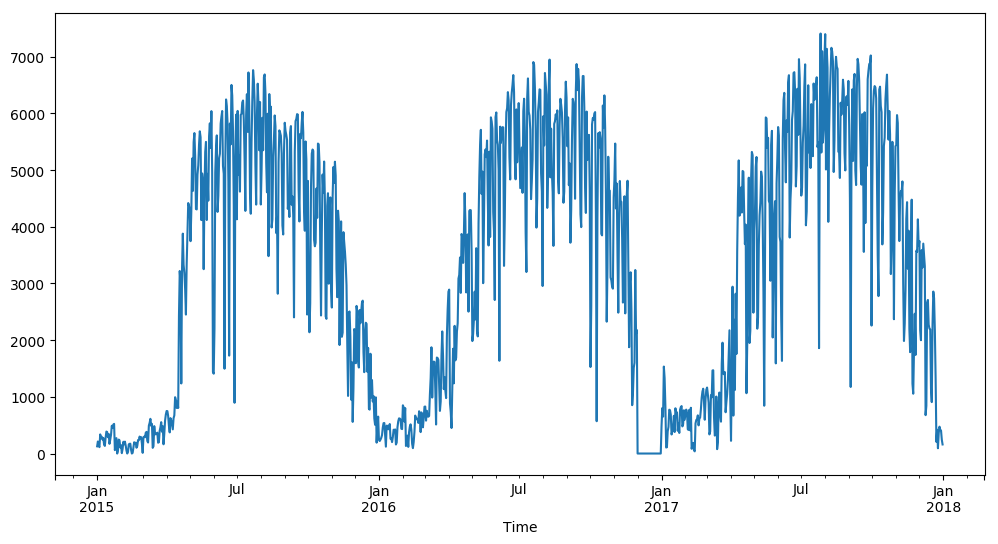

In [164]:
R_day.plot(figsize=(12,6));

In [165]:
# check autocorrelation for previous two weeks
for i in range(1,22):
    print(i, R_day.autocorr(lag=i))

1 0.898395922290517
2 0.8308675823500036
3 0.8088353437161352
4 0.8044092504363498
5 0.8126920873931801
6 0.8522227231452747
7 0.8722980487561288
8 0.8390496989323457
9 0.7910389723234393
10 0.7716090332734495
11 0.7733608129026375
12 0.7935498130598733
13 0.8255389715508467
14 0.8455340317522482
15 0.8039870822096887
16 0.7582929813593885
17 0.7433522843944687
18 0.7335356761024086
19 0.7453533271421299
20 0.7802883722692204
21 0.8001583119563336


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.



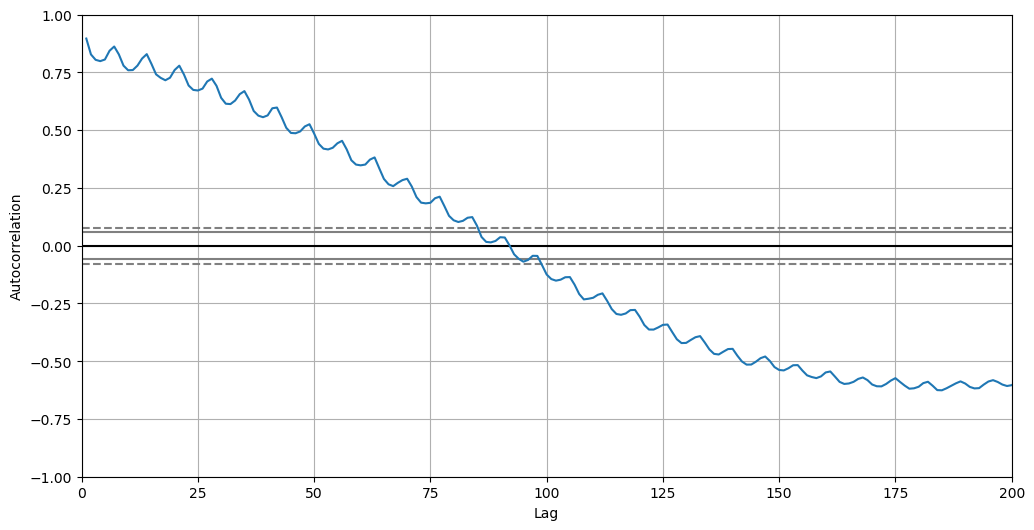

In [166]:
# plot autocorrelation for different lags using pandas
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(12,6))

autocorrelation_plot(R_day)
plt.xlim(0,200);

#plot shows high autocorrelation accross lags

### Weekly Autocorrelation

In [167]:
# resample all data to weekly counts
R_week = start_df.BikeID.resample("W").count()
R_week.head(10)

Time
2015-01-04     594
2015-01-11    1718
2015-01-18    2092
2015-01-25    2527
2015-02-01    1058
2015-02-08     862
2015-02-15     598
2015-02-22     910
2015-03-01    1513
2015-03-08    2038
Freq: W-SUN, Name: BikeID, dtype: int64

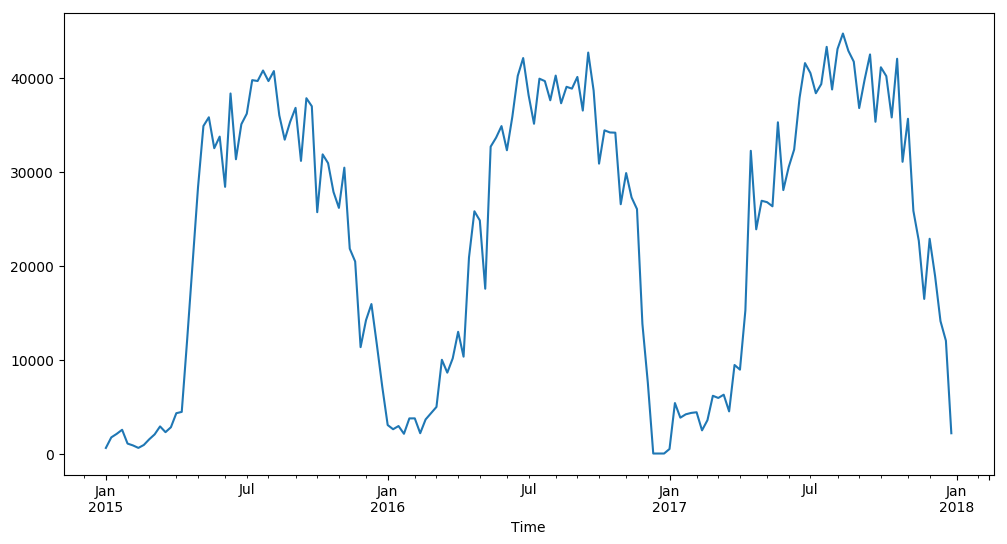

In [168]:
R_week.plot(figsize=(12, 6));

In [169]:
# check autocorrelation for previous 6 weeks
for i in range(1,13):
    print(i, R_week.autocorr(lag=i))

1 0.9502441974922681
2 0.9157635234702208
3 0.86756224861828
4 0.8129888368045604
5 0.7515093035085848
6 0.6737771747931616
7 0.5932699629612084
8 0.5099275505654657
9 0.42537254920911705
10 0.3199101611897409
11 0.22718533605982938
12 0.12002920439757357


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.



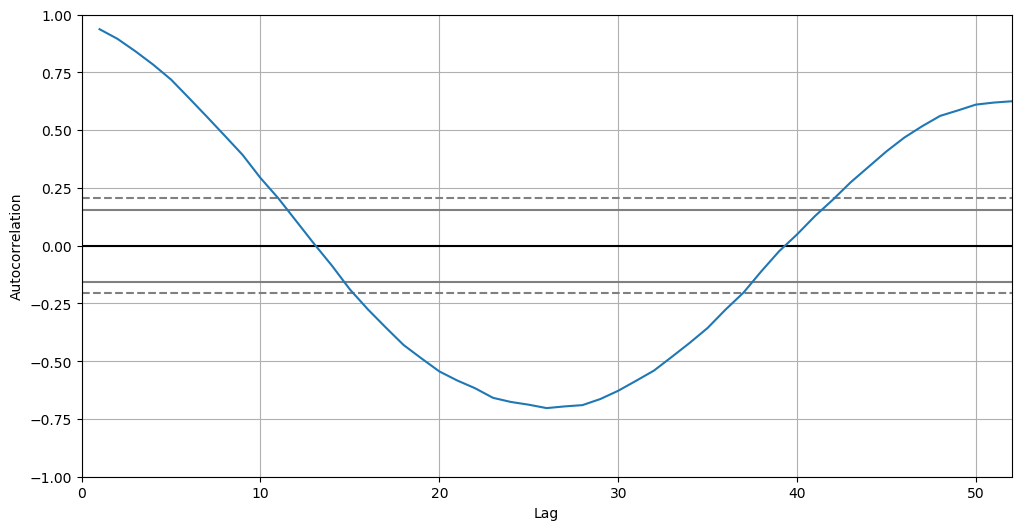

In [170]:
# plot autocorrelation for different lags using pandas
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(12,6))

autocorrelation_plot(R_week)
plt.xlim(0,52);

#plot shows high autocorrelation accross lags

### Monthly Autocorrelation

In [171]:
# resample all data to montly counts
R_month = start_df.BikeID.resample("M").count()
R_month.head(10)

Time
2015-01-31      7840
2015-02-28      4020
2015-03-31     11270
2015-04-30     55843
2015-05-31    149143
2015-06-30    144232
2015-07-31    175321
2015-08-31    160065
2015-09-30    150516
2015-10-31    126656
Freq: M, Name: BikeID, dtype: int64

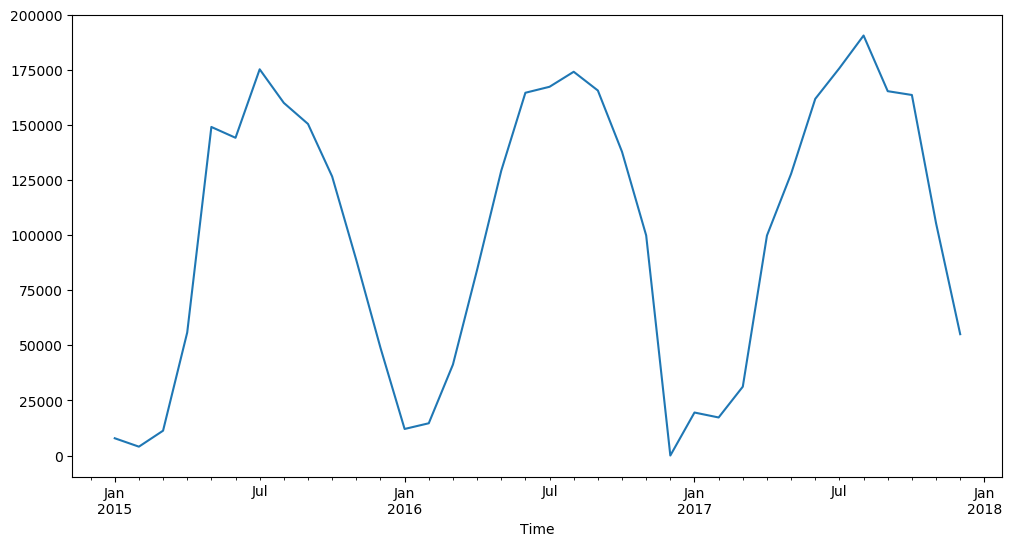

In [172]:
R_month.plot(figsize=(12,6));

In [173]:
# check autocorrelation for previous 6 months
for i in range(1,7):
    print(i, R_month.autocorr(lag=i))

1 0.8217338960617172
2 0.471999013228521
3 0.0022386583585920633
4 -0.4747548739976758
5 -0.7744651197904647
6 -0.917378920927986


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.



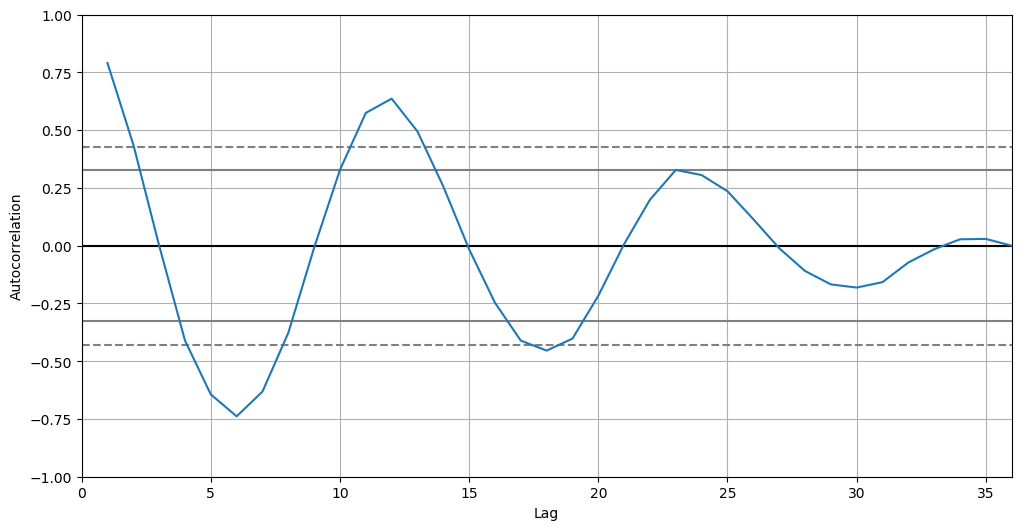

In [174]:
# plot autocorrelation for different lags using pandas
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(12,6))

autocorrelation_plot(R_month);
plt.xlim(0,36);

#plot shows high autocorrelation accross lags

### Autocorrelation by user type (member/subscriber)

In [175]:
start_df.UserType.value_counts()

Member    2798424
Casual     829119
Name: UserType, dtype: int64

In [176]:
# resample all data to daily counts
df_usertype = pd.get_dummies(start_df.UserType)

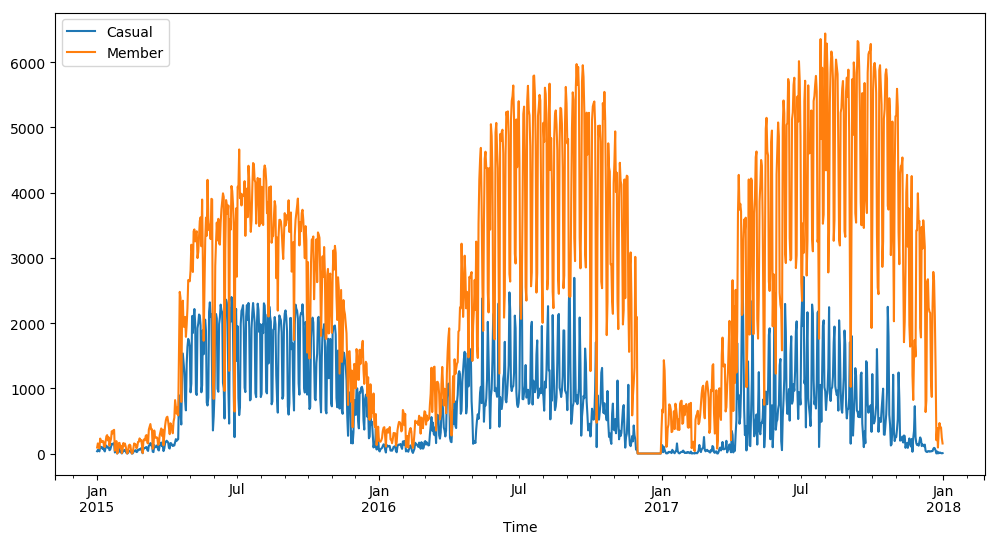

In [177]:
R_usertype_day = df_usertype.resample("D").sum()
R_usertype_day.plot(figsize=(12,6));

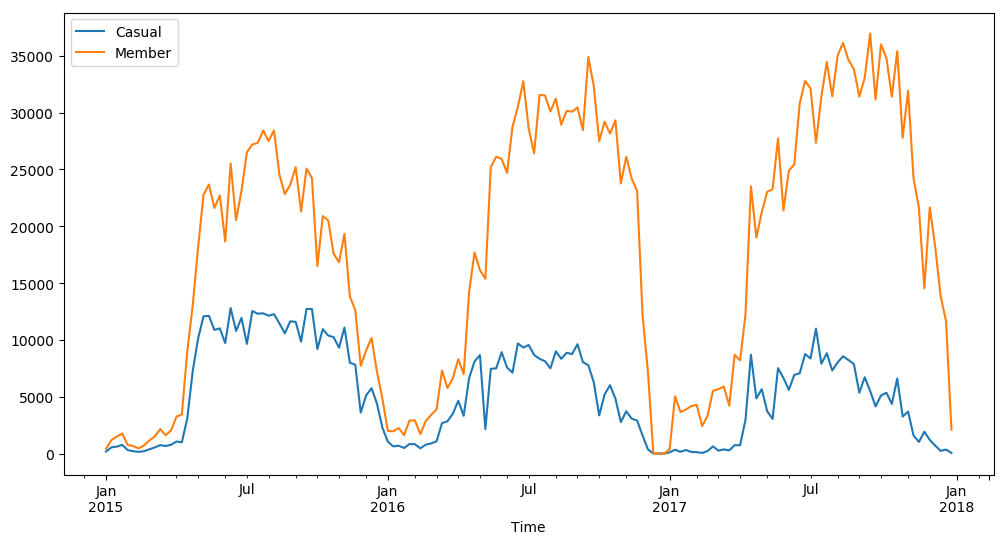

In [178]:
R_usertype_week = df_usertype.resample("W").sum()
R_usertype_week.plot(figsize=(12,6));

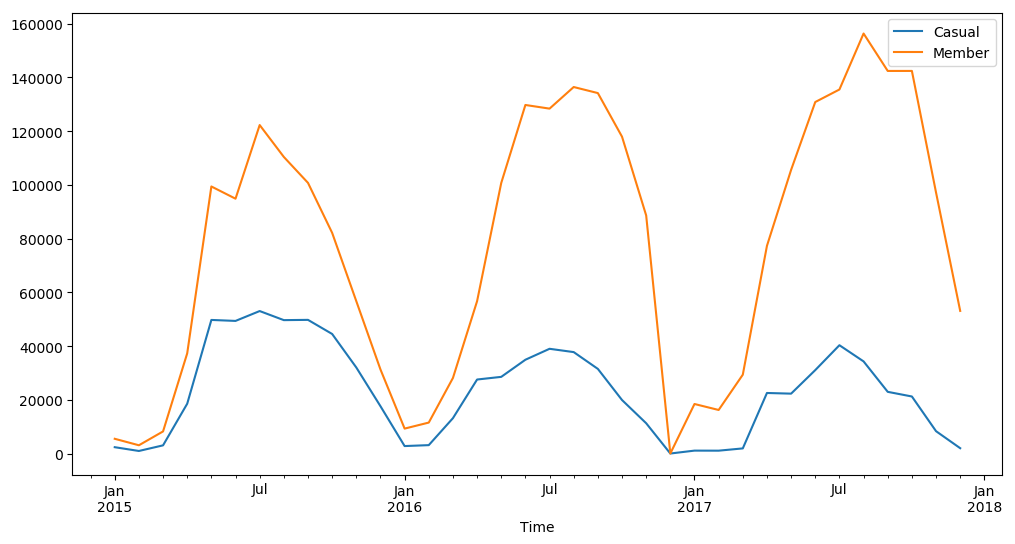

In [179]:
R_usertype_month = df_usertype.resample("M").sum()
R_usertype_month.plot(figsize=(12,6));

### Check Stationarity of Time Series
A time series is stationary is the mean and standard deviation is constant overtime. Most time series models assume the time series is stationary, so it's importat to check so we can account for this later.

Dickey-Fuller Test: This is a statistical check to test for stationarity. The null-hypothesis assumes that the time series is not stationary. If the p-value output is below our threshold (0.05) then we can reject the null- hypothesis and assume the time series is stationary.

In [180]:
from statsmodels.tsa.stattools import adfuller

In [181]:
def test_stationarity(timeseries):
    
    """
    ===============================
    This function tests the stationarity of a timeseries
    ===============================
    Input: time series dataframe or array
    ===============================
    Output: Dickey-Fuller Test and graph ploting rolling mean and standard deviation
    ===============================
    """
    
    #Perform Dickey-Fuller test:
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig, ax = plt.subplots(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

Results of Dickey-Fuller Test:
Test Statistic                   -1.991168
p-value                           0.290459
#Lags Used                       22.000000
Number of Observations Used    1073.000000
Critical Value (1%)              -3.436459
Critical Value (5%)              -2.864237
Critical Value (10%)             -2.568206
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



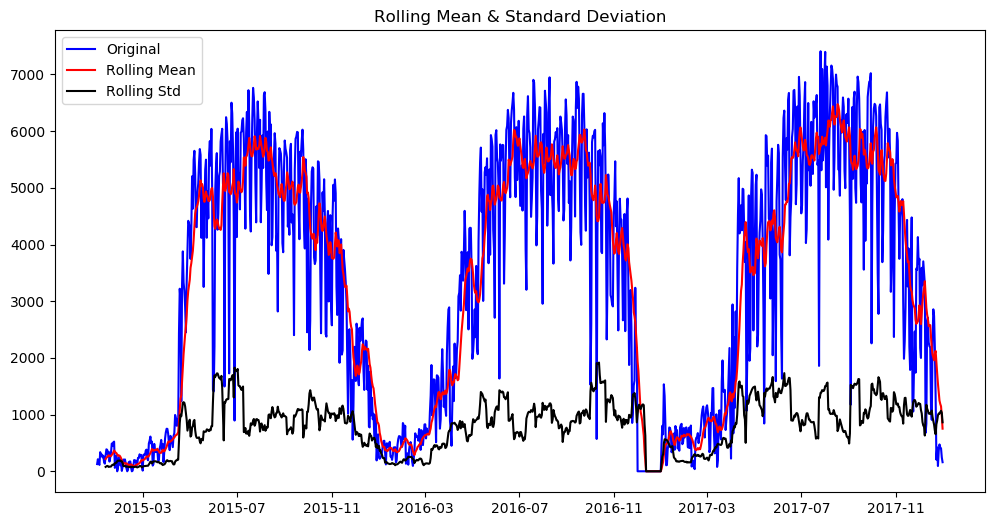

In [182]:
test_stationarity(R_day)

Results of Dickey-Fuller Test:
Test Statistic                   -1.991168
p-value                           0.290459
#Lags Used                       22.000000
Number of Observations Used    1073.000000
Critical Value (1%)              -3.436459
Critical Value (5%)              -2.864237
Critical Value (10%)             -2.568206
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



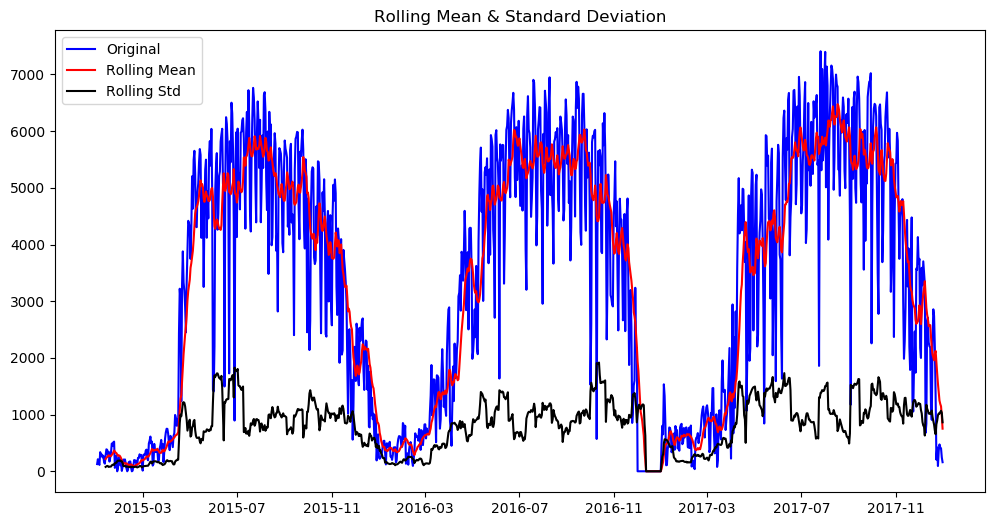

In [183]:
test_stationarity(R_day)

Results of Dickey-Fuller Test:
Test Statistic                  -5.254953
p-value                          0.000007
#Lags Used                      14.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



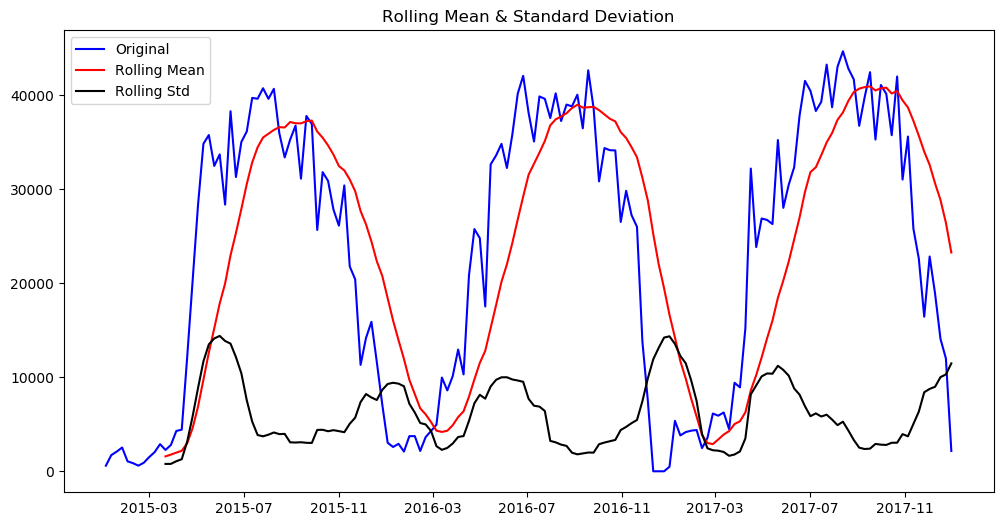

In [184]:
test_stationarity(R_week)

Results of Dickey-Fuller Test:
Test Statistic                 -4.786425
p-value                         0.000058
#Lags Used                      7.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



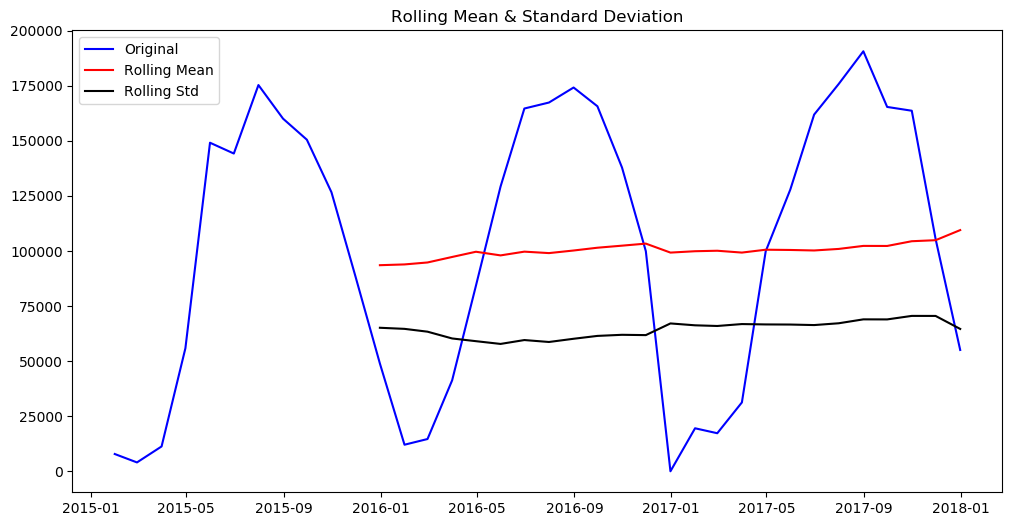

In [185]:
test_stationarity(R_month)

### Remove Stationarity
The Dickey-Fuller test shows that the data is not stationary. There is a clear seasonal trend with a growth in bike usage during the warmer summer months.

A SARIMA model assumes the data is stationary, so this needs to be removed before we run our model.

The first thing we want to do is take a first difference of the data. This should help to eliminate the overall trend from the data.

Results of Dickey-Fuller Test:
Test Statistic                   -1.991168
p-value                           0.290459
#Lags Used                       22.000000
Number of Observations Used    1073.000000
Critical Value (1%)              -3.436459
Critical Value (5%)              -2.864237
Critical Value (10%)             -2.568206
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



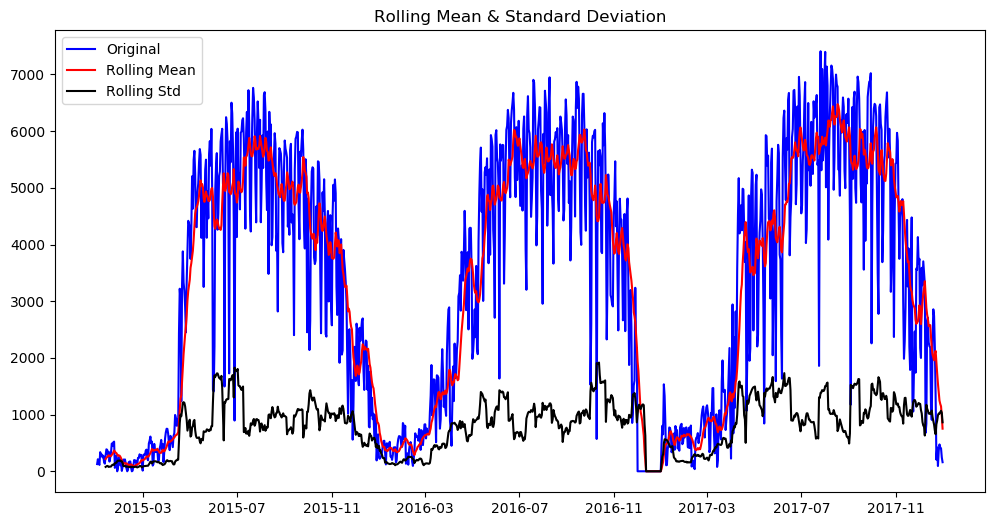

In [186]:
test_stationarity(R_day.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -5.652925e+00
p-value                        9.766902e-07
#Lags Used                     2.200000e+01
Number of Observations Used    1.066000e+03
Critical Value (1%)           -3.436499e+00
Critical Value (5%)           -2.864255e+00
Critical Value (10%)          -2.568216e+00
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



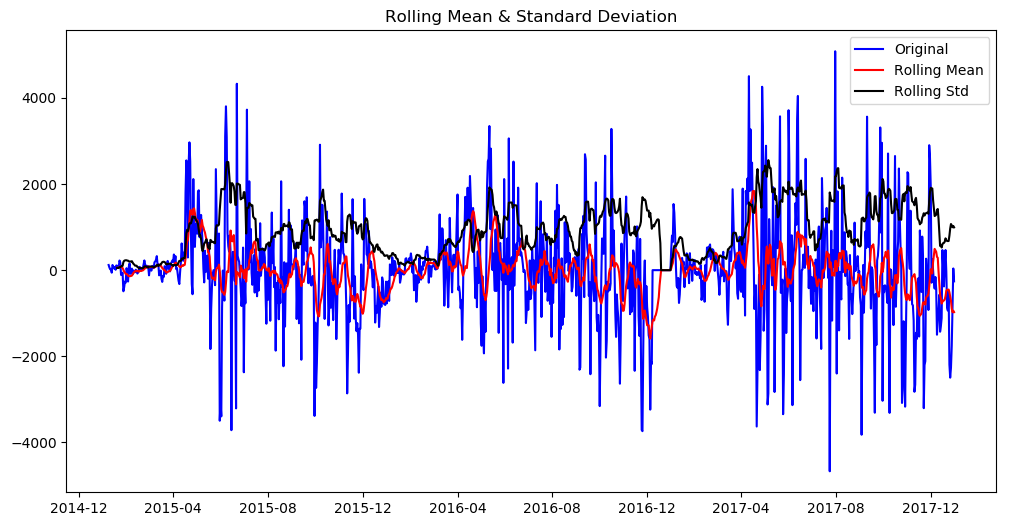

In [187]:
first_difference = R_day - R_day.shift(7)
test_stationarity(first_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -7.221540e+00
p-value                        2.105077e-10
#Lags Used                     2.100000e+01
Number of Observations Used    1.073000e+03
Critical Value (1%)           -3.436459e+00
Critical Value (5%)           -2.864237e+00
Critical Value (10%)          -2.568206e+00
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



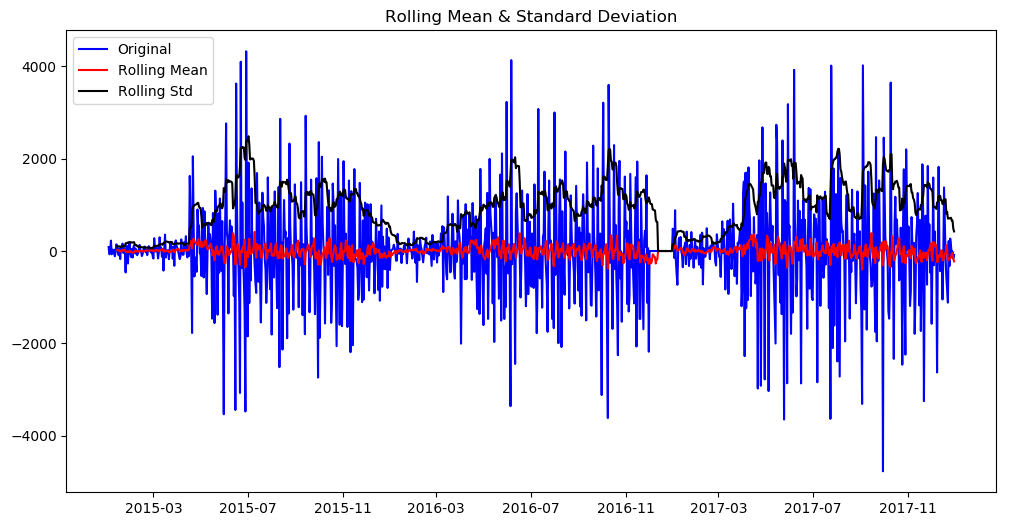

In [188]:
first_difference = R_day - R_day.shift(1)
test_stationarity(first_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                   -3.233092
p-value                           0.018147
#Lags Used                       22.000000
Number of Observations Used    1043.000000
Critical Value (1%)              -3.436635
Critical Value (5%)              -2.864315
Critical Value (10%)             -2.568248
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



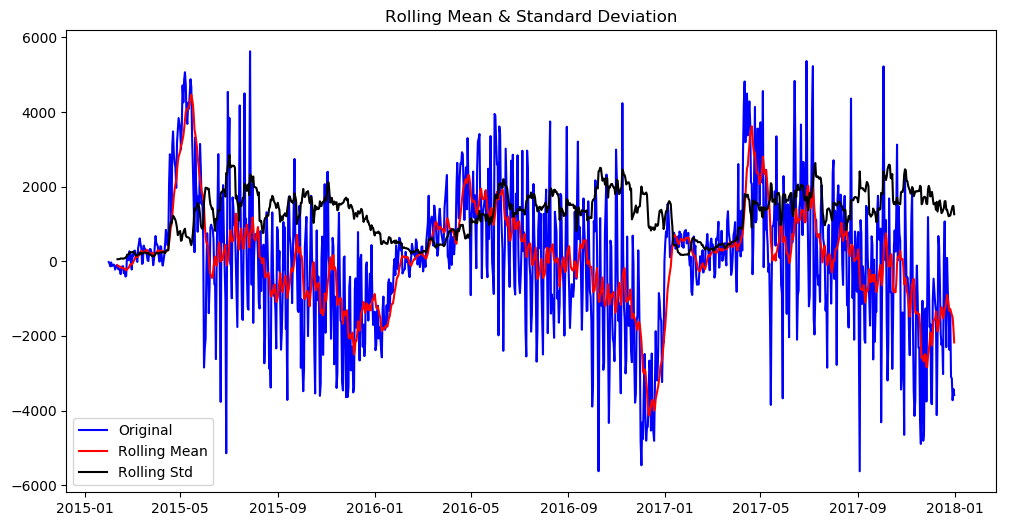

In [189]:
seasonal_difference = R_day - R_day.shift(30)
test_stationarity(seasonal_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                  -5.254953
p-value                          0.000007
#Lags Used                      14.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



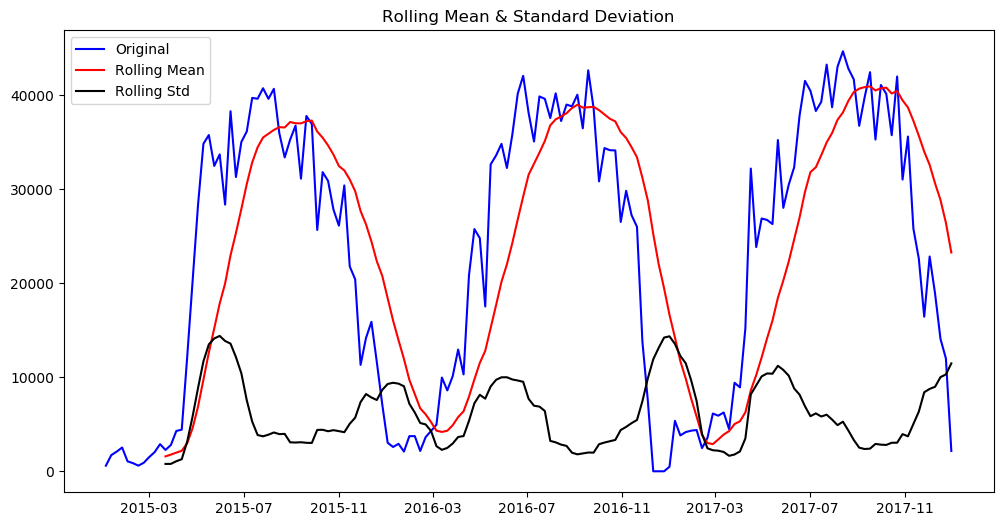

In [190]:
test_stationarity(R_week.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -5.823935e+00
p-value                        4.121196e-07
#Lags Used                     2.000000e+00
Number of Observations Used    1.530000e+02
Critical Value (1%)           -3.473830e+00
Critical Value (5%)           -2.880623e+00
Critical Value (10%)          -2.576945e+00
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



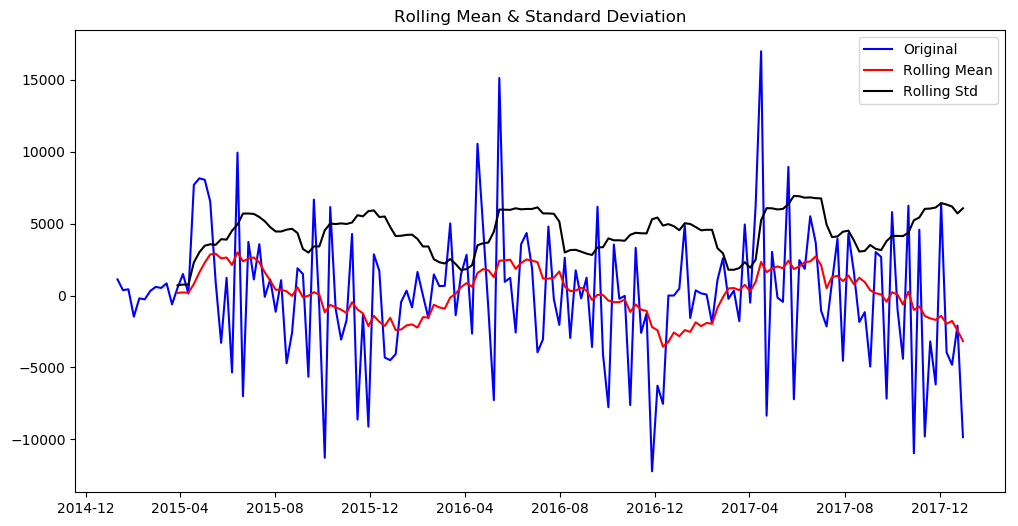

In [191]:
seasonal_difference_week = R_week - R_week.shift(1)
seasonal_difference_week
test_stationarity(seasonal_difference_week.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                 -4.786425
p-value                         0.000058
#Lags Used                      7.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



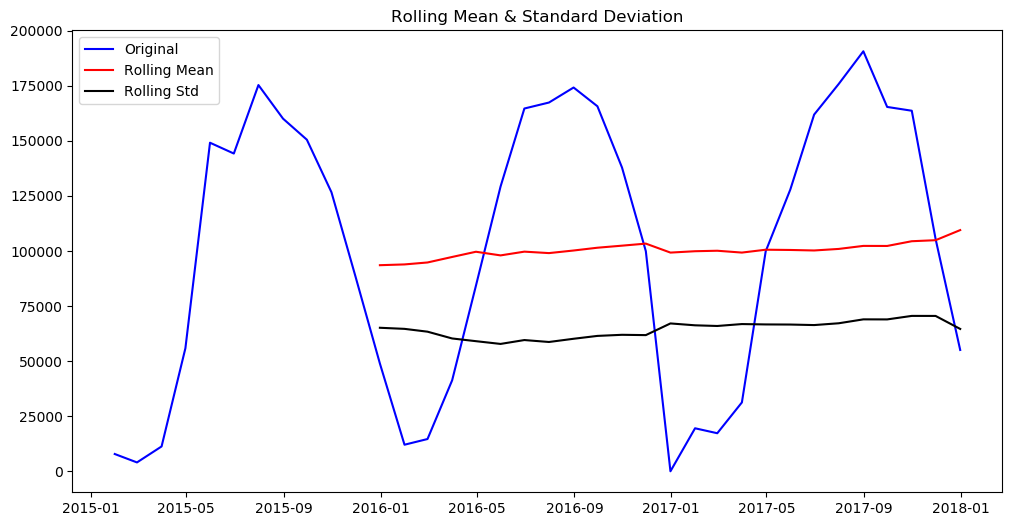

In [192]:
test_stationarity(R_month.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                 -5.495922
p-value                         0.000002
#Lags Used                      9.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



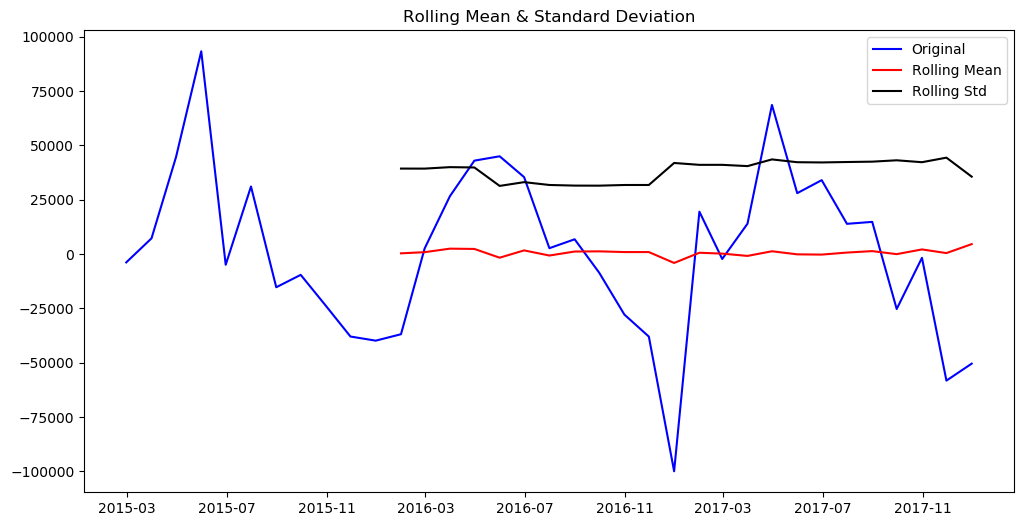

In [193]:
seasonal_difference = R_month - R_month.shift(1)
seasonal_difference
test_stationarity(seasonal_difference.dropna(inplace=False))

### General Seasonal Autoregressive Integrated Moving Average Model (SARIMA)
The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.

In [194]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt
import seaborn as sns

def plots(data, lags=None, fig=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0), fig=fig)
    acf  = plt.subplot2grid(layout, (0, 1), fig=fig)
    pacf = plt.subplot2grid(layout, (0, 2), fig=fig)
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

### SARIMA Model for Day

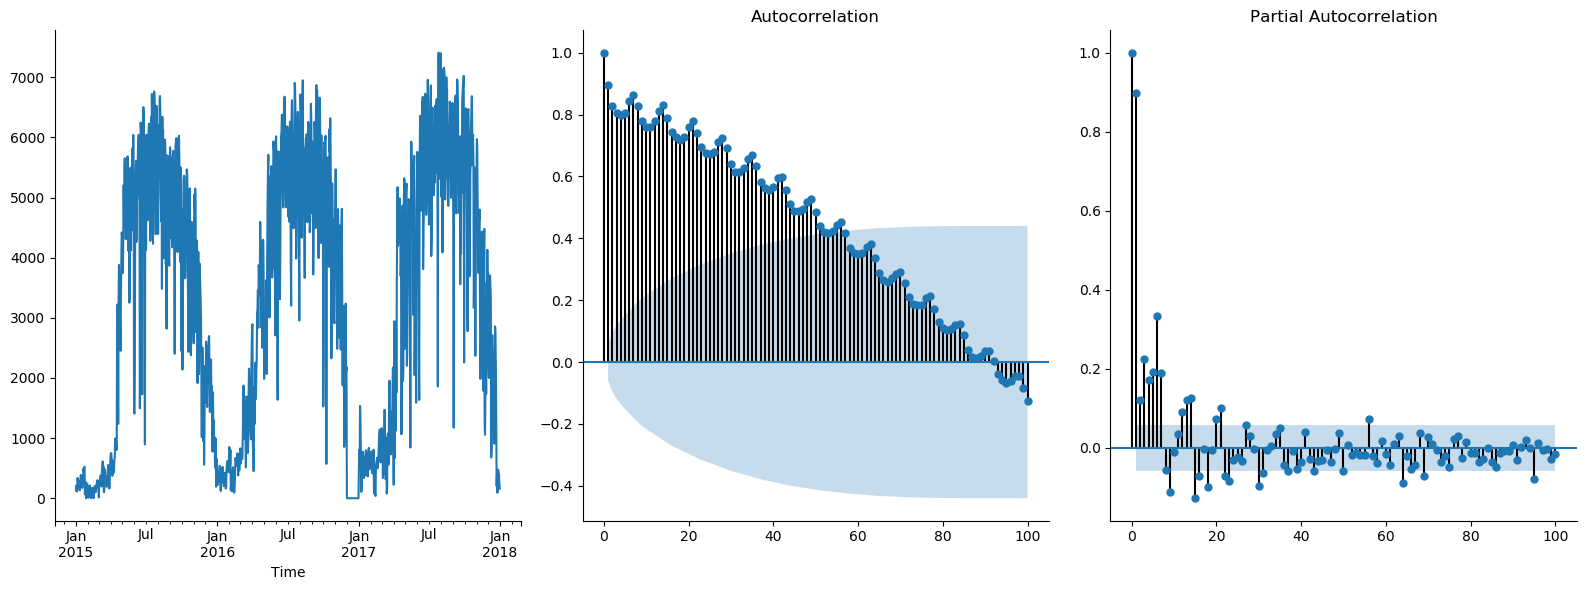

In [195]:
fig, ax = plt.subplots(figsize=(16, 6))
plots(R_day, lags=100, fig=fig)

In [196]:
# check daily deviations for various diffs
print('Raw STD:', R_day.std())
print('1st Order Difference STD:', R_day.diff().std())
print('2nd Order Difference STD:', R_day.diff().diff().std())
print('3rd Order Difference STD:', R_day.diff().diff().diff().std())

Raw STD: 2289.9332916916583
1st Order Difference STD: 1031.839070968895
2nd Order Difference STD: 1578.496965259998
3rd Order Difference STD: 2713.7023164560173


In [197]:
# fit SARIMA on daily counts
# first we look at acf and pacf
import statsmodels.api as sm
# sarima_day = sm.tsa.statespace.SARIMAX(R_day, order=(1,0,7), seasonal_order=(2,1,1,7), trend="c").fit()
sarima_day = sm.tsa.statespace.SARIMAX(R_day, order=(0,1,4), seasonal_order=(0,1,4,7), mle_regression=False, trend="c").fit()
# print(sarima_day.summary())
sarima_day.summary()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                            BikeID   No. Observations:                 1096
Model:             SARIMAX(0, 1, 4)x(0, 1, 4, 7)   Log Likelihood               -8935.270
Date:                           Tue, 03 Apr 2018   AIC                          17890.540
Time:                                   08:00:38   BIC                          17940.534
Sample:                               01-01-2015   HQIC                         17909.457
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.9541      2.254      1.311      0.190      -1.463       7.371
ma.L1         -0.5632      0.042    -13.421      0.000      -0.645      -0.481
ma.L2         -0.2722      0.056     -4.857      0.000      -0.382      -0.162
ma.L3          0.1663      0.052      3.190      0.001       0.064       0.269
ma.L4         -0.0739      0.049     -1.496      0.135      -0.171       0.023
ma.S.L7       -0.8870      0.043    -20.424      0.000      -0.972      -0.802
ma.S.L14       0.0671      0.056      1.198      0.231      -0.043       0.177
ma.S.L21      -0.0401      0.058     -0.687      0.492      -0.155       0.074
ma.S.L28       0.0039      0.046      0.084      0.933      -0.086       0.094
sigma2      1.207e+06   5.75e+04     21.002      0.000    1.09e+06    1.32e+06
===================================================================================
Ljung-Box (Q):                       93.22   Jarque-Bera (JB):              1076.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                            -1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

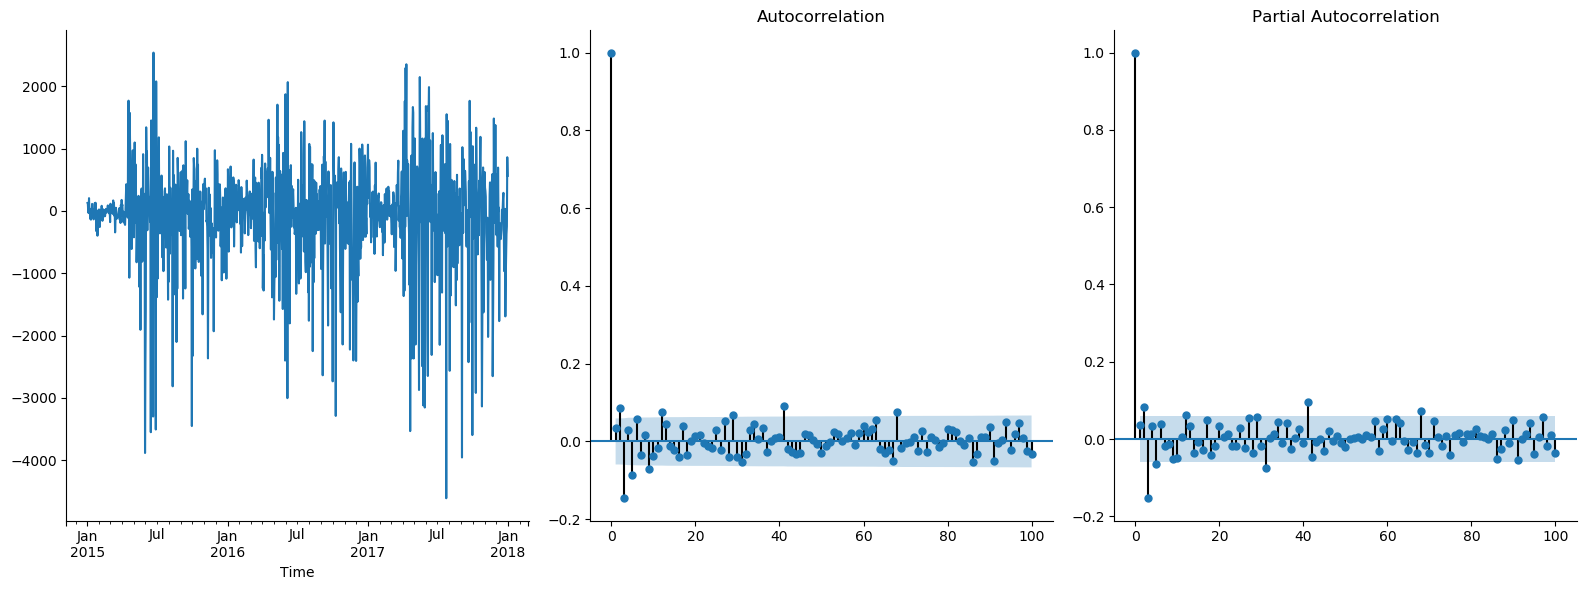

In [198]:
# look at resids to find patterns and update sarima
fig, ax = plt.subplots(figsize=(16, 6))
plots(sarima_day.resid, lags=100, fig=fig)

/home/cneiderer/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



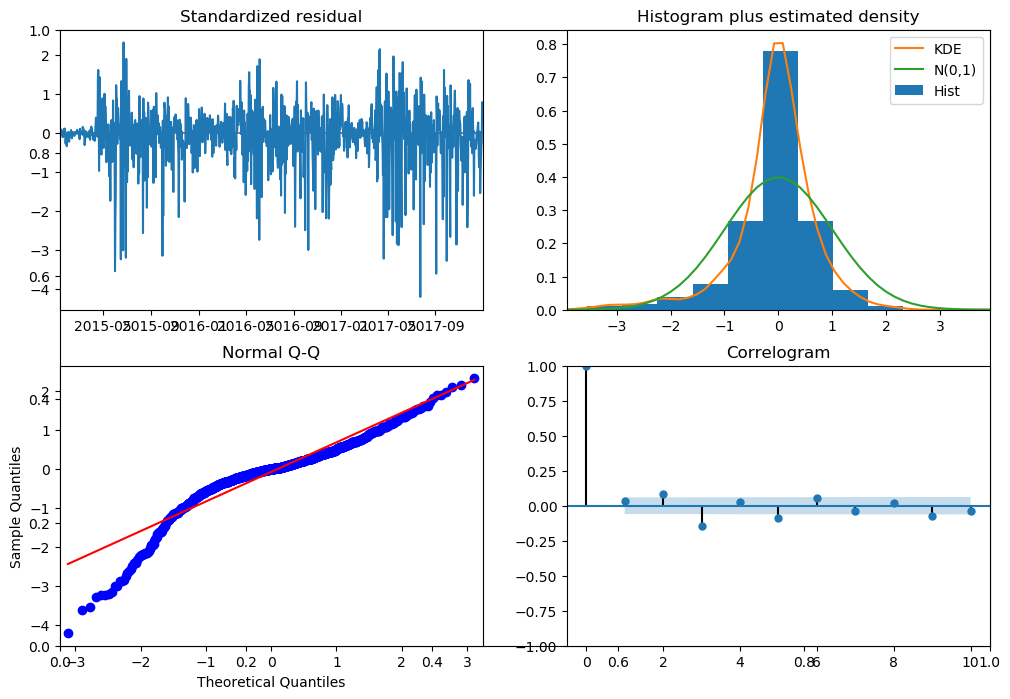

In [199]:
fig, ax = plt.subplots(figsize=(12, 8))
sarima_day.plot_diagnostics(fig=fig);

### SARIMA Model for Week

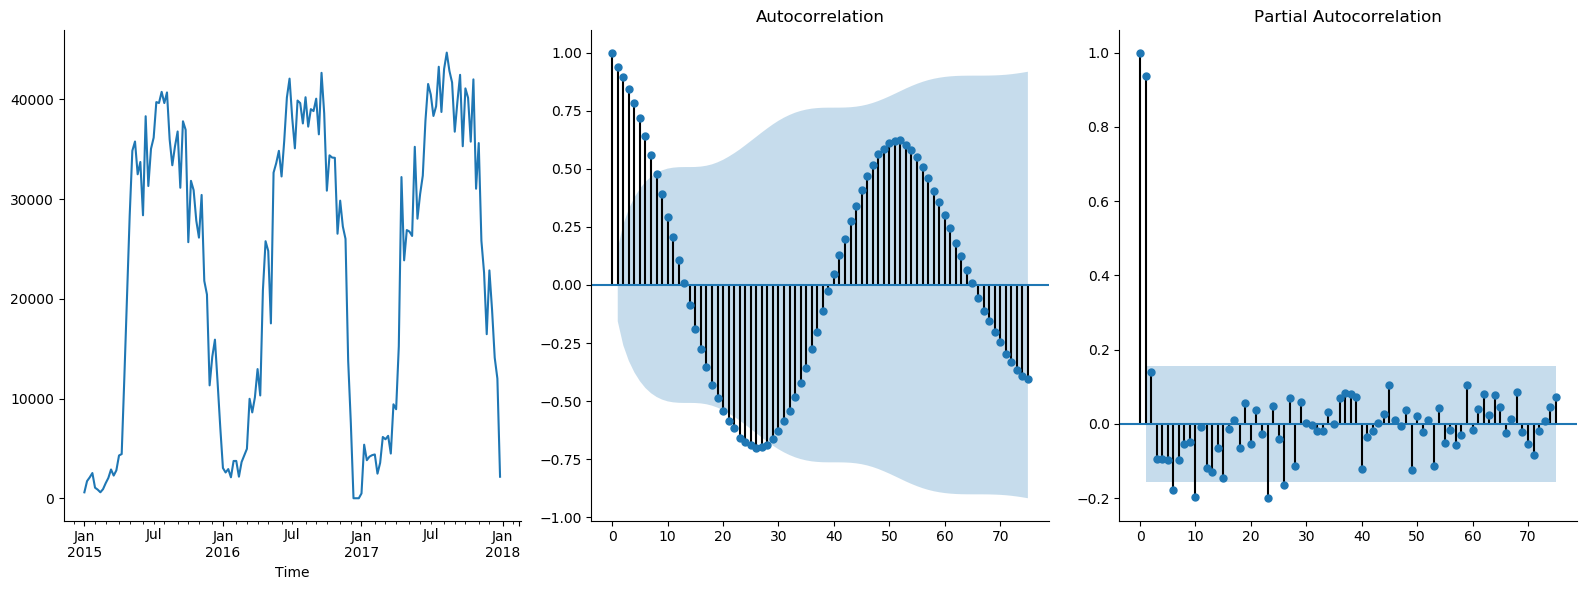

In [201]:
fig, ax = plt.subplots(figsize=(16, 6))
plots(R_week, lags=75, fig=fig)

In [202]:
R_week.head()

Time
2015-01-04     594
2015-01-11    1718
2015-01-18    2092
2015-01-25    2527
2015-02-01    1058
Freq: W-SUN, Name: BikeID, dtype: int64

In [203]:
# check weekly deviations for various diffs
print('Raw STD:', R_week.std())
print('1st Order Difference STD:', R_week.diff().std())
print('2nd Order Difference STD:', R_week.diff().diff().std())
print('3rd Order Difference STD:', R_week.diff().diff().diff().std())

Raw STD: 14957.399021583073
1st Order Difference STD: 4701.219742167336
2nd Order Difference STD: 7095.87222869505
3rd Order Difference STD: 12806.560798802371


In [204]:
# fit SARIMA on weekly counts
# first we look at acf and pacf
import statsmodels.api as sm
# sarima_week = sm.tsa.statespace.SARIMAX(R_week, order=(1,0,5), seasonal_order=(2,1,0,52), trend="c").fit()
# sarima_week = sm.tsa.statespace.SARIMAX(R_week, order=(0,0,0), seasonal_order=(2,1,0,52), trend="c").fit()
# sarima_week = sm.tsa.statespace.SARIMAX(R_week, order=(0,1,1), seasonal_order=(1,1,0,52), trend="c").fit()
sarima_week = sm.tsa.statespace.SARIMAX(R_week, order=(2,0,0), seasonal_order=(2,1,0,52), mle_regression=False, trend="c").fit()
# sarima_week = sm.tsa.statespace.SARIMAX(R_week, order=(1,0,1), seasonal_order=(2,1,1,26), mle_regression=False, trend="c").fit()
print(sarima_week.summary())

# plt.plot(sarima_week.resid, "bo")
# print(plot_acf(sarima_week.resid, lags=100))
# print(plot_pacf(sarima_week.resid, lags=100))

                                 Statespace Model Results                                 
Dep. Variable:                             BikeID   No. Observations:                  157
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 52)   Log Likelihood               -1030.415
Date:                            Tue, 03 Apr 2018   AIC                           2072.830
Time:                                    08:02:51   BIC                           2091.167
Sample:                                01-04-2015   HQIC                          2080.277
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    925.9069   1212.450      0.764      0.445   -1450.452    3302.266
ar.L1          0.6869      0.114   

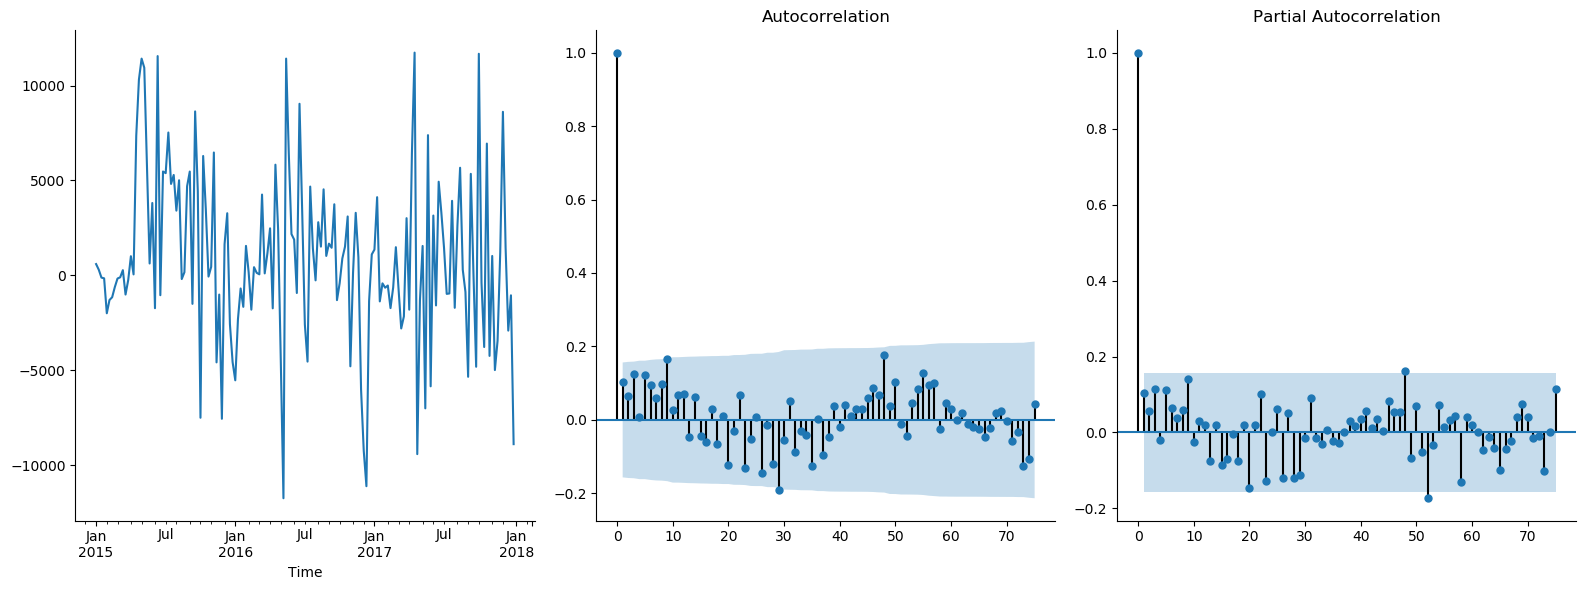

In [205]:
fig, ax = plt.subplots(figsize=(16, 6))
plots(sarima_week.resid, lags=75, fig=fig)

/home/cneiderer/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



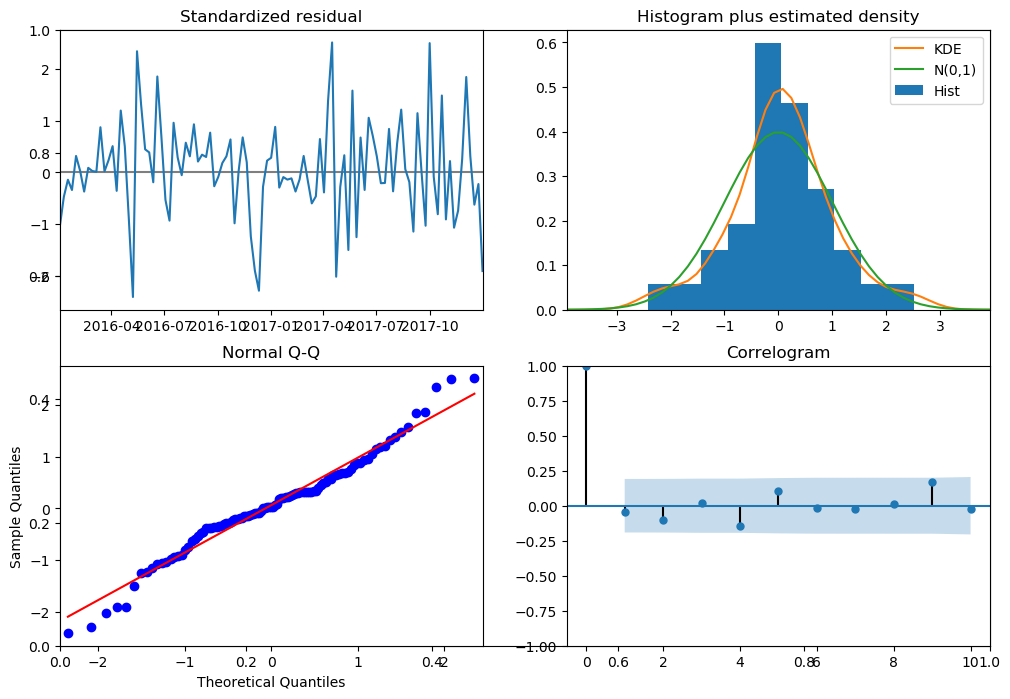

In [206]:
fig, ax = plt.subplots(figsize=(12, 8))
sarima_week.plot_diagnostics(fig=fig);

### SARIMA Model for Month

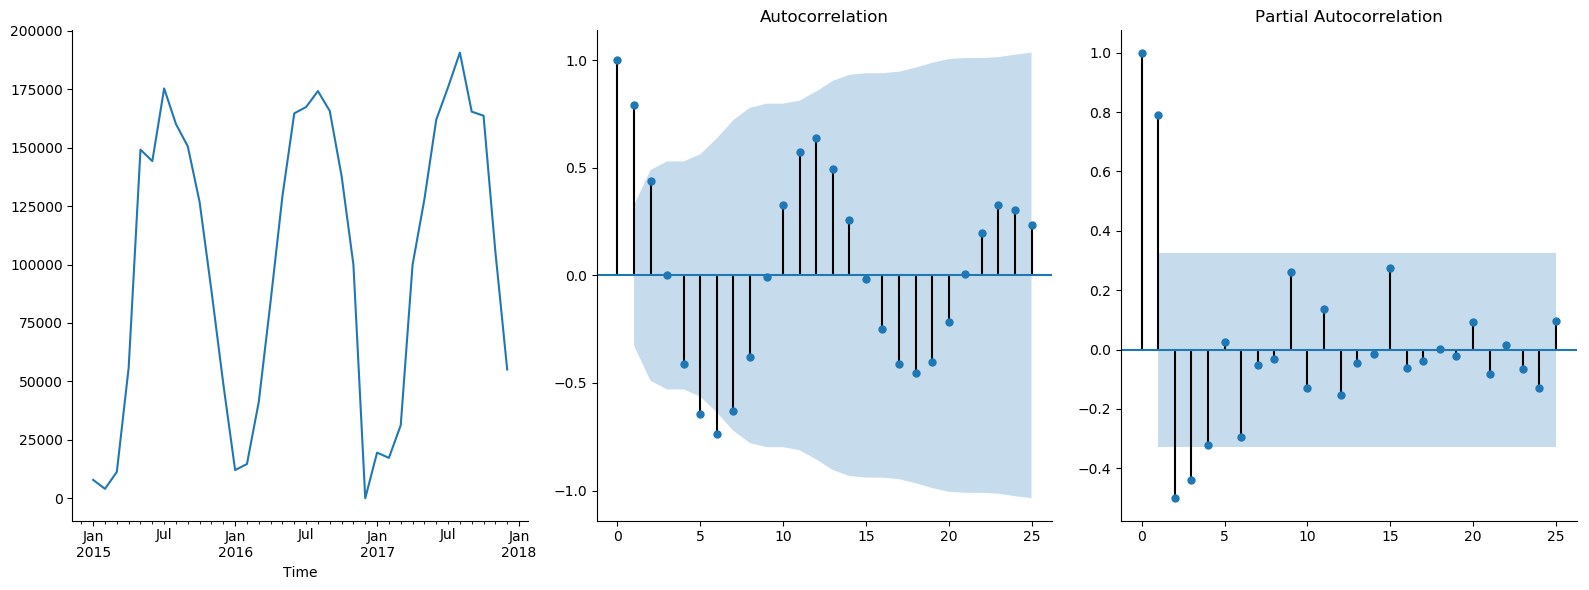

In [208]:
fig, ax = plt.subplots(figsize=(16, 6))
plots(R_month, lags=25, fig=fig)

In [209]:
# check weekly deviations for various diffs
print('Raw STD:', R_month.std())
print('1st Order Difference STD:', R_month.diff().std())
print('2nd Order Difference STD:', R_month.diff().diff().std())
print('3rd Order Difference STD:', R_month.diff().diff().diff().std())

Raw STD: 64078.350299067475
1st Order Difference STD: 38093.90676331895
2nd Order Difference STD: 39303.249561319004
3rd Order Difference STD: 66583.65178955399


In [210]:
# fit SARIMA on monthly counts
# first we look at acf and pacf
import statsmodels.api as sm
# sarima_month = sm.tsa.statespace.SARIMAX(R_month, order=(0,1,1), seasonal_order=(1,0,0,12), trend="c").fit()
# sarima_month = sm.tsa.statespace.SARIMAX(R_month, order=(4,1,0), seasonal_order=(1,1,0,12), trend="c").fit()
sarima_month = sm.tsa.statespace.SARIMAX(R_month, order=(0,1,0), seasonal_order=(1,1,0,12), mle_regression=False, trend="c").fit()
print(sarima_month.summary())

# plt.plot(sarima_month.resid, "bo")
# print(plot_acf(sarima_month.resid, lags=25))
# print(plot_pacf(sarima_month.resid, lags=25))

                                 Statespace Model Results                                 
Dep. Variable:                             BikeID   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -266.019
Date:                            Tue, 03 Apr 2018   AIC                            538.039
Time:                                    08:03:47   BIC                            542.789
Sample:                                01-31-2015   HQIC                           539.697
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2211.1739   7912.969      0.279      0.780   -1.33e+04    1.77e+04
ar.S.L12      -0.3187      0.201   

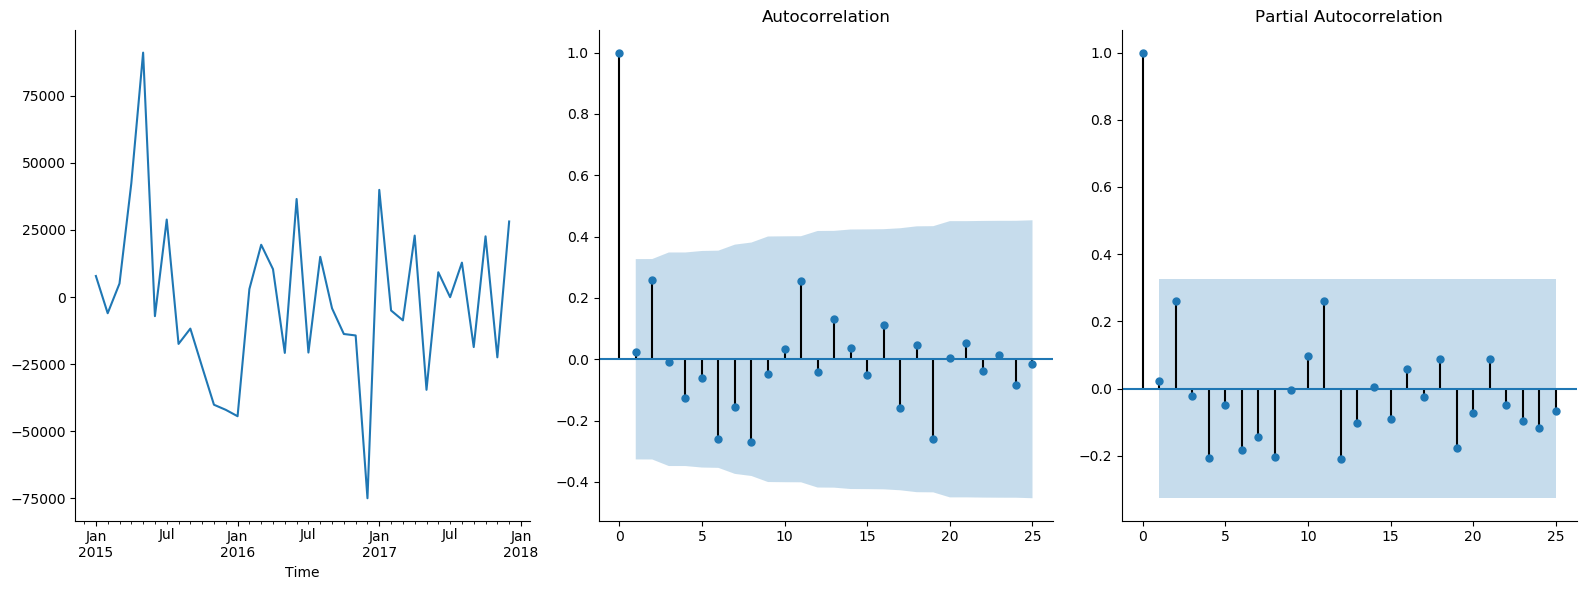

In [211]:
fig, ax = plt.subplots(figsize=(16, 6))
plots(sarima_month.resid, lags=25, fig=fig)

/home/cneiderer/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



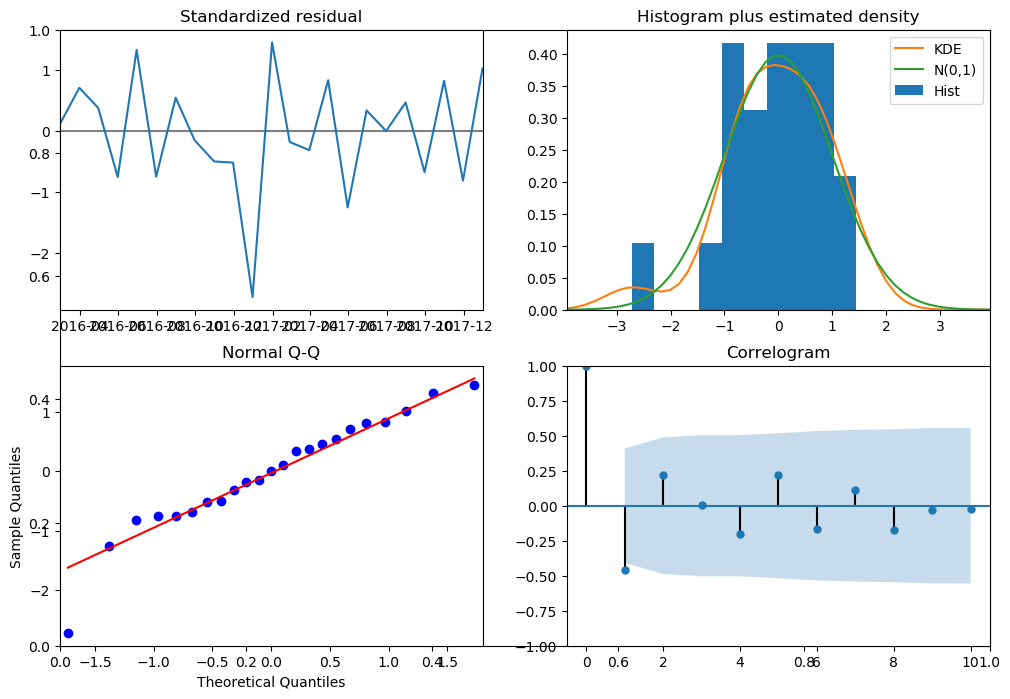

In [212]:
fig, ax = plt.subplots(figsize=(12, 8))
sarima_month.plot_diagnostics(fig=fig);

### General Forecasting

In [213]:
R_day.head()

Time
2015-01-01    127
2015-01-02    213
2015-01-03    142
2015-01-04    112
2015-01-05    337
Freq: D, Name: BikeID, dtype: int64

In [214]:
R_week.head()

Time
2015-01-04     594
2015-01-11    1718
2015-01-18    2092
2015-01-25    2527
2015-02-01    1058
Freq: W-SUN, Name: BikeID, dtype: int64

In [215]:
R_month.head()

Time
2015-01-31      7840
2015-02-28      4020
2015-03-31     11270
2015-04-30     55843
2015-05-31    149143
Freq: M, Name: BikeID, dtype: int64

In [545]:
#turn daily series into dataframe and add prediction column
df_day = R_day.to_frame()
df_day.rename(columns={"BikeID" : "Count"}, inplace=True)

#turn weekly series into dataframe and add prediction column
df_week = R_week.to_frame()
df_week.rename(columns={"BikeID" : "Count"}, inplace=True)

#turn monthly series into dataframe and add prediction column
df_month = R_month.to_frame()
df_month.rename(columns={"BikeID" : "Count"}, inplace=True)

In [546]:
def bound_prediction(predict):
    predict[predict < 0] = 0
    return predict

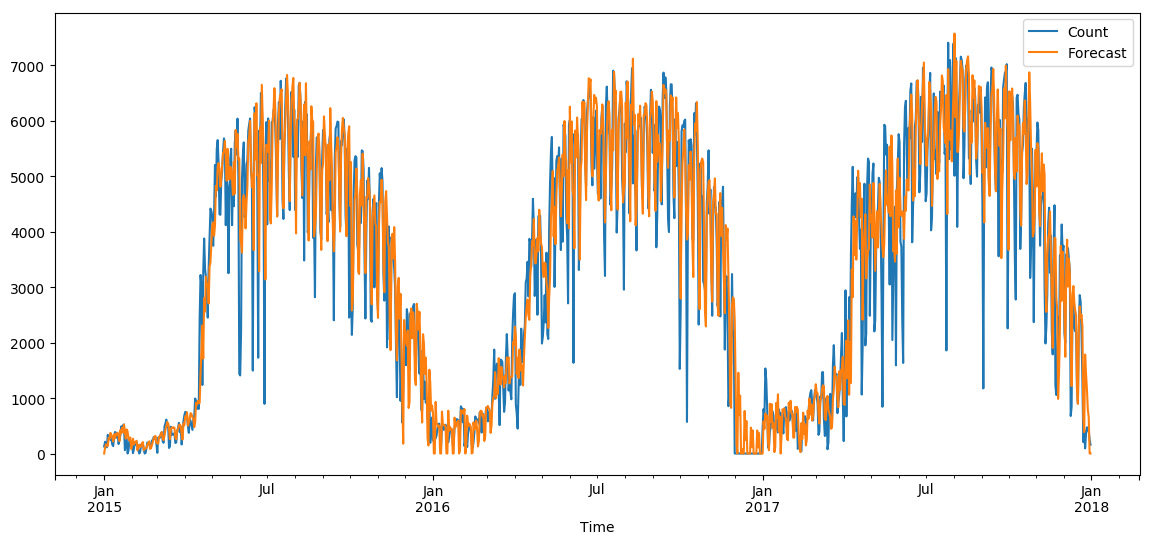

In [547]:
#plot daily actual and forecast
df_day['Forecast'] = bound_prediction(sarima_day.predict())
df_day
df_day.plot(figsize=(14, 6));

In [548]:
df_day.head(10)

Count    Forecast
Time                         
2015-01-01    127    0.000000
2015-01-02    213  104.676101
2015-01-03    142  164.868239
2015-01-04    112  147.496503
2015-01-05    337  132.904278
2015-01-06    267  283.209363
2015-01-07    296  261.460836
2015-01-08    247  372.562663
2015-01-09    275  332.483073
2015-01-10    162  302.662832

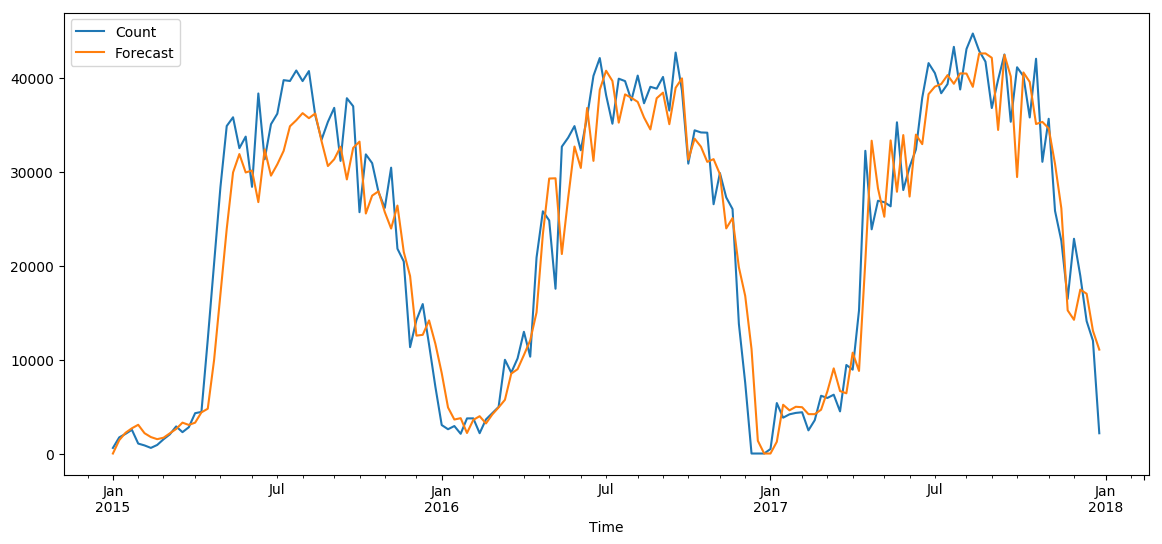

In [549]:
#plot weekly actual and forecast
df_week['Forecast'] = bound_prediction(sarima_week.predict())
df_week
df_week.plot(figsize=(14, 6));

In [559]:
df_week

Count      Forecast
Time                           
2015-01-04    594      0.000000
2015-01-11   1718   1423.214278
2015-01-18   2092   2211.300084
2015-01-25   2527   2685.535615
2015-02-01   1058   3057.702518
2015-02-08    862   2164.324852
2015-02-15    598   1752.457619
2015-02-22    910   1527.268123
2015-03-01   1513   1681.199947
2015-03-08   2038   2142.344015
2015-03-15   2885   2612.142984
2015-03-22   2273   3285.090245
2015-03-29   2795   3044.892592
2015-04-05   4290   3282.409248
2015-04-12   4429   4379.393898
2015-04-19  12120   4765.219415
2015-04-26  20266   9945.733610
2015-05-03  28311  16884.995404
2015-05-10  34849  23901.101328
2015-05-17  35778  29903.553798
2015-05-24  32489  31864.540651
2015-05-31  33721  29907.045335
2015-06-07  28376  30109.171154
2015-06-14  38310  26750.851191
2015-06-21  31312  32359.991669
2015-06-28  35041  29566.836527
2015-07-05  36159  30771.394932
2015-07-12  39729  32199.132707
2015-07-19  39638  34820.182768
2015-07-26  40755  35462.161319
2015-08-02  39629  36217.504320
2015-08-09  40695  35682.459825
2015-08-16  35985  36181.418897
2015-08-23  33395  33229.523503
2015-08-30  35288  30588.818628
2015-09-06  36782  31310.621977
2015-09-13  31137  32640.881902
2015-09-20  37806  29163.879730
2015-09-27  36951  32523.699529
2015-10-04  25679  33187.603624
2015-10-11  31830  25537.517550
2015-10-18  30898  27440.310915
2015-10-25  27834  27898.097625
2015-11-01  26136  25687.002516
2015-11-08  30416  23939.504678
2015-11-15  21795  26384.004785
2015-11-22  20433  21447.177121
2015-11-29  11320  18883.150327
2015-12-06  14189  12544.669860
2015-12-13  15904  12629.897514
2015-12-20  11594  14164.196276
2015-12-27   7102  11672.763623
2016-01-03   3031   8565.146070
2016-01-10   2585   4898.789290
2016-01-17   2925   3618.284478
2016-01-24   2100   3760.879656
2016-01-31   3737   2184.717958
2016-02-07   3741   3580.509187
2016-02-14   2161   3971.000065
2016-02-21   3629   3199.015995
2016-02-28   4286   4154.179320
2016-03-06   4958   4905.286262
2016-03-13   9973   5714.582589
2016-03-20   8605   8502.660318
2016-03-27  10123   8973.154281
2016-04-03  12953  10474.984732
2016-04-10  10307  12046.611972
2016-04-17  20852  15018.739016
2016-04-24  25775  23334.166942
2016-05-01  24803  29261.128499
2016-05-08  17534  29286.211170
2016-05-15  32654  21227.338543
2016-05-22  33607  27189.541203
2016-05-29  34839  32664.200568
2016-06-05  32269  30384.409323
2016-06-12  35837  36768.360532
2016-06-19  40184  31139.109587
2016-06-26  42081  38705.053819
2016-07-03  38135  40730.767471
2016-07-10  35090  39638.580452
2016-07-17  39884  35204.507310
2016-07-24  39628  38214.544903
2016-07-31  37586  37850.636229
2016-08-07  40215  37414.087574
2016-08-14  37269  35755.317426
2016-08-21  39020  34486.010588
2016-08-28  38828  37804.047484
2016-09-04  40070  38399.192423
2016-09-11  36493  35040.067117
2016-09-18  42663  38916.989124
2016-09-25  38610  39917.441528
2016-10-02  30845  31261.311926
2016-10-09  34390  33499.598513
2016-10-16  34164  32648.763864
2016-10-23  34140  31035.736480
2016-10-30  26527  31323.300969
2016-11-06  29843  29723.310336
2016-11-13  27250  23954.011488
2016-11-20  26010  25052.666401
2016-11-27  13795  19819.630008
2016-12-04   7531  16778.222409
2016-12-11      0  11117.577375
2016-12-18      0   1355.750799
2016-12-25      0      0.000000
2017-01-01    481      0.000000
2017-01-08   5370   1249.436837
2017-01-15   3814   5188.029455
2017-01-22   4172   4595.326701
2017-01-29   4321   4974.018931
2017-02-05   4391   4928.252477
2017-02-12   2465   4192.365089
2017-02-19   3549   4185.615249
2017-02-26   6144   4660.337953
2017-03-05   5913   6621.778624
2017-03-12   6259   9059.399706
2017-03-19   4482   6646.266739
2017-03-26   9421   6407.125129
2017-04-02   8925  10734.425257
2017-04-09  15233   8786.701912
2017-04-16  32210  20467.751128
2017-04-23  23858  33284.226846
2017-04-30  26895  28211.122049
2017-05-07  26745  25196.310771
2017-05-14  

In [551]:
df_week.Forecast = df_week.Forecast.astype('float')

In [554]:
np.diff(df_week.as_matrix(), axis=1)

array([[  -594.        ],
       [  -294.7857218 ],
       [   119.30008398],
       [   158.53561481],
       [  1999.70251807],
       [  1302.32485219],
       [  1154.45761947],
       [   617.26812323],
       [   168.19994739],
       [   104.34401477],
       [  -272.8570158 ],
       [  1012.09024518],
       [   249.89259213],
       [ -1007.59075195],
       [   -49.60610156],
       [ -7354.78058491],
       [-10320.26638985],
       [-11426.00459567],
       [-10947.89867224],
       [ -5874.44620198],
       [  -624.45934919],
       [ -3813.95466454],
       [  1733.17115405],
       [-11559.14880892],
       [  1047.99166927],
       [ -5474.16347305],
       [ -5387.60506751],
       [ -7529.86729297],
       [ -4817.81723159],
       [ -5292.83868119],
       [ -3411.49567966],
       [ -5012.54017467],
       [   196.41889653],
       [  -165.4764973 ],
       [ -4699.18137227],
       [ -5471.3780228 ],
       [  1503.88190191],
       [ -8642.12026983],
       [ -44

In [557]:
from sklearn.metrics import mean_absolute_error, r2_score

In [556]:
mean_absolute_error(df_week.Count, df_week.Forecast)

3336.8822280399622

In [558]:
r2_score(df_week.Count, df_week.Forecast)

0.9069037476192431

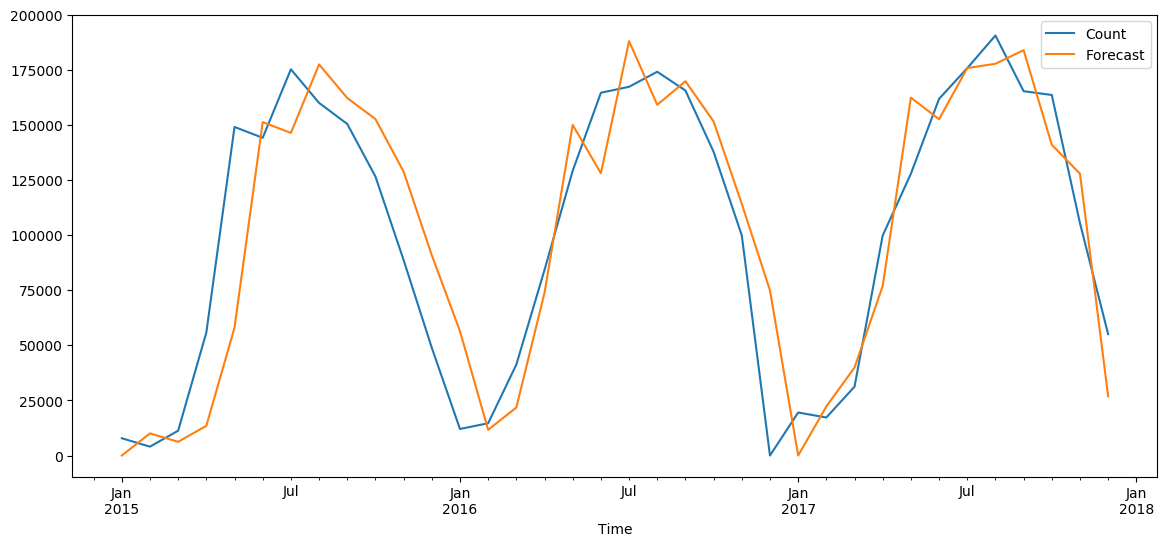

In [222]:
#plot monthly actual and forecast
df_month['Forecast'] = bound_prediction(sarima_month.predict())
df_month.plot(figsize=(14,6));

In [223]:
df_month.head(10)

Count      Forecast
Time                            
2015-01-31    7840       0.00000
2015-02-28    4020   10051.17391
2015-03-31   11270    6231.17391
2015-04-30   55843   13481.17391
2015-05-31  149143   58054.17391
2015-06-30  144232  151354.17391
2015-07-31  175321  146443.17391
2015-08-31  160065  177532.17391
2015-09-30  150516  162276.17391
2015-10-31  126656  152727.17391

### Show Projections into the Future

In [224]:
#add daily dates to df_day
start = dt.strptime("2018-01-01", "%Y-%m-%d")
day_list = [start + relativedelta(days=x) for x in range(0,365)]
future_day = pd.DataFrame(index=day_list, columns= df_day.columns)
df_day = pd.concat([df_day, future_day])

In [225]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2015-01-01 to 2018-12-31
Data columns (total 2 columns):
Count       1096 non-null object
Forecast    1096 non-null float64
dtypes: float64(1), object(1)
memory usage: 34.2+ KB


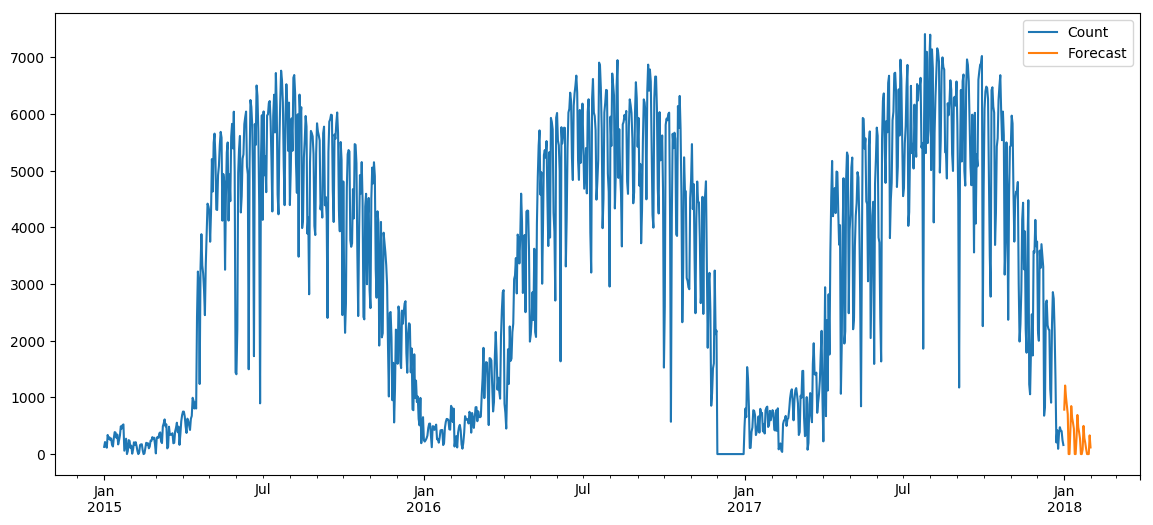

In [226]:
start_idx = 1096
future_days = 30
end_idx = start_idx+future_days
df_day['Forecast'] = bound_prediction(sarima_day.predict(start=start_idx, end=end_idx, dynamic=True))
df_day
df_day.plot(figsize=(14, 6));

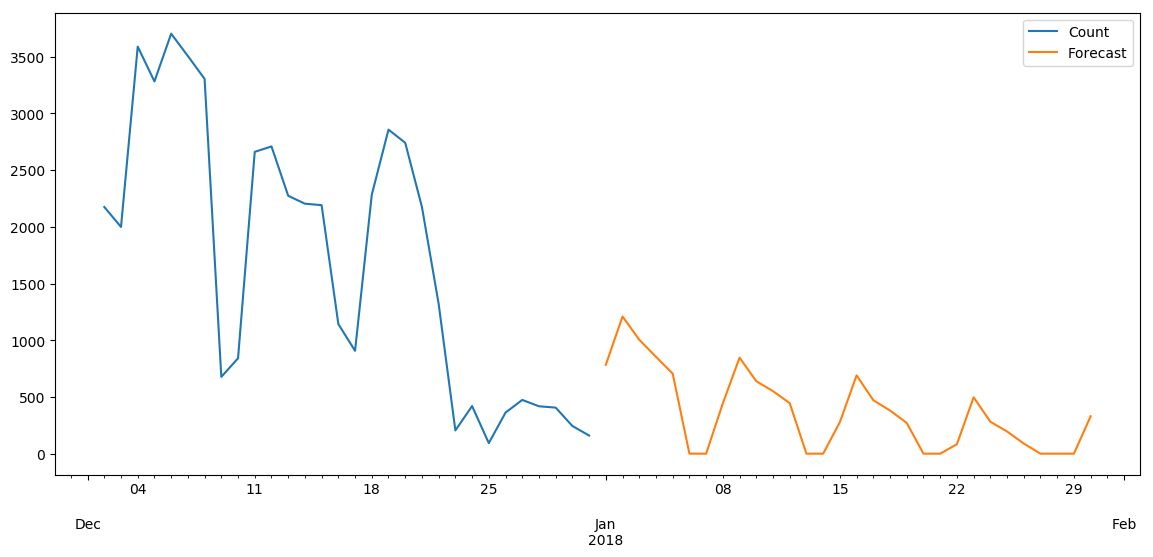

In [227]:
#plot the last few days of data and project days into the future
df_day_recent = df_day.iloc[start_idx-future_days:end_idx]
df_day_recent.plot(figsize=(14, 6));

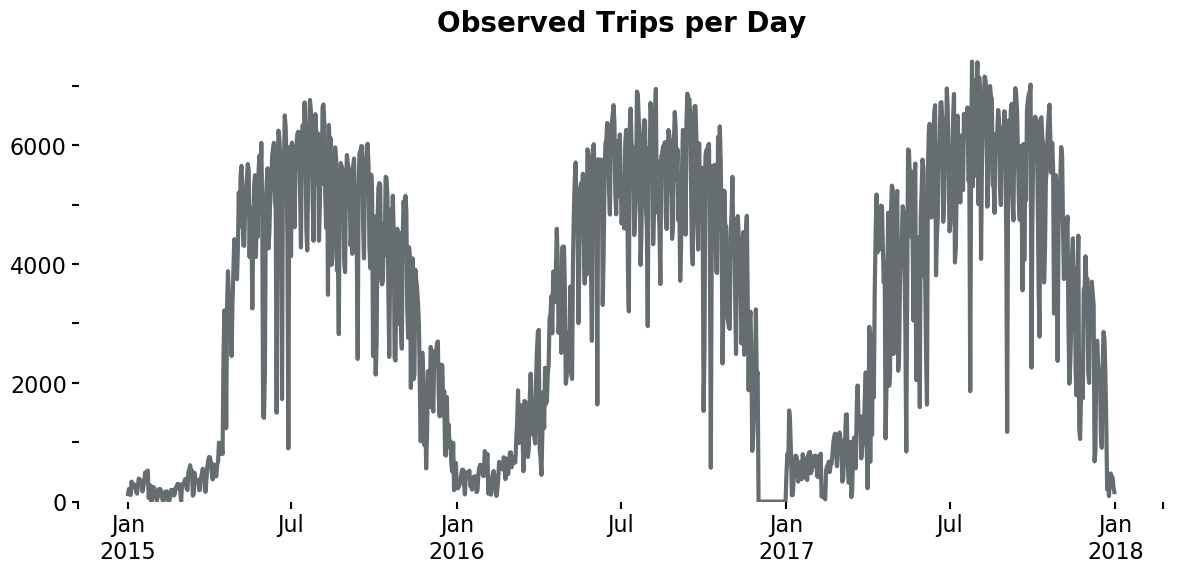

In [376]:
pred = sarima_day.get_prediction(start=365*3, end=365*3+30, dynamic=True)
pred_ci = pred.conf_int()

plt.style.use('default')
plt_color = '7d868c'
plt_color = 'white'
fig,ax = plt.subplots(figsize=(14,6), facecolor=plt_color)

ax = R_day.plot(color='#3e484e', lw=3, alpha=0.8, label='Observed', ax=ax) # '#7d868c', '#3e484e'

ax.set_title('Observed Trips per Day', fontdict={'size': 20, 'weight': 'bold'})
ax.set_yticks(np.arange(0, 8000, 1000), minor=True)
ax.set_yticks(np.arange(0, 8000, 2000), minor=False)
ax.set_ylim(bottom=0)

ax.set_xticks([16617, 16983, 17348], minor=True)
ax.set_xticklabels(['Jul', 'Jul', 'Jul'], minor=True)
ax.set_xlabel('')

fs = 16
ax.tick_params(which='both', axis='both', labelsize=fs, width=1.5, length=5)
ax.set_frame_on(0)

major_ticks = ax.get_xticks(minor=False) 
minor_ticks = ax.get_xticks(minor=True)
major_ticklabels = ax.get_xticklabels(minor=False)
minor_ticklabels = ax.get_xticklabels(minor=True)

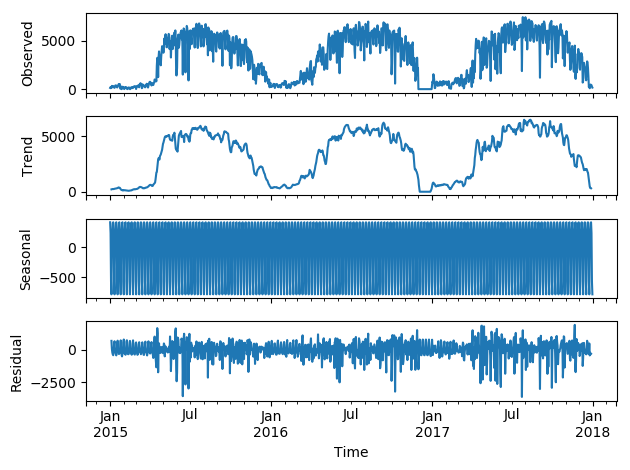

In [381]:
# decompose data into trend, seasonal, and residual
decomposition = sm.tsa.seasonal_decompose(R_day, model='additive', freq=7)
fig = decomposition.plot()

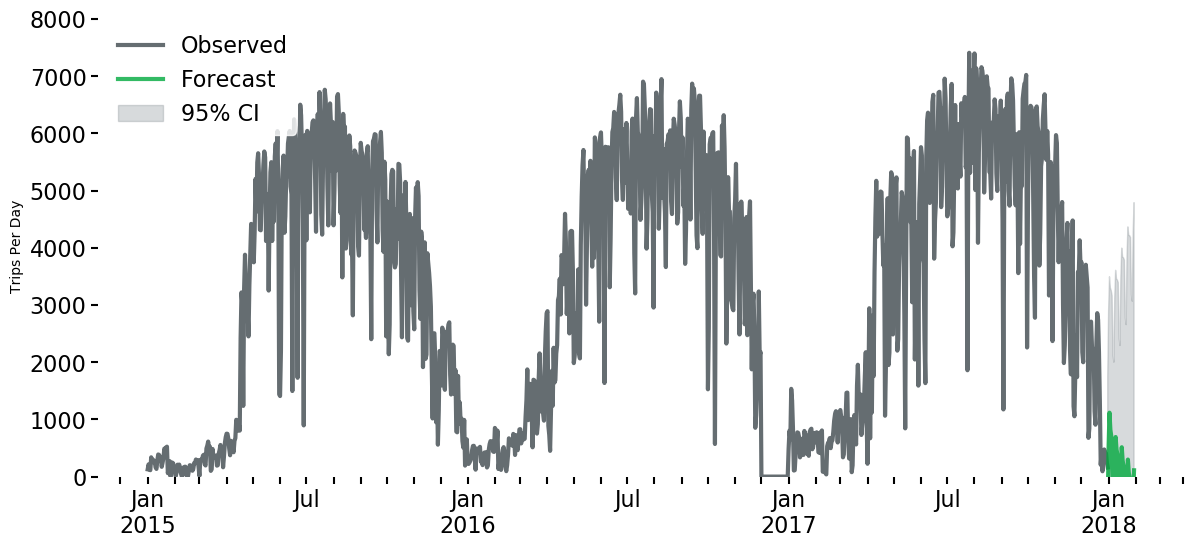

In [229]:
pred = sarima_day.get_prediction(start=365*3, end=365*3+30, dynamic=True)
pred_ci = pred.conf_int()

plt.style.use('default')
plt_color = '7d868c'
plt_color = 'white'
fig,ax = plt.subplots(figsize=(14,6), facecolor=plt_color)

ax = R_day.plot(color='#3e484e', lw=3, alpha=0.8, label='Observed', ax=ax) # '#7d868c', '#3e484e'
pred.predicted_mean.plot(color='#00a93d', lw=3, alpha=0.8, label='Forecast', ax=ax) # this is using all available info
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='#7d868c', alpha=0.3, label='95% CI')
ax.set_xlabel('')
ax.set_ylabel('Trips Per Day')
ax.set_ylim(bottom=0)

fs = 16
ax.tick_params(which='both', axis='both', labelsize=fs, width=1.5, length=5)
ax.legend(fontsize=fs, frameon=True, facecolor=plt_color, edgecolor=plt_color, loc=2) #, prop={'weight': 'bold'})
ax.set_frame_on(0)
test = ax.get_yticklabels()

In [230]:
#add weekly dates to df_week
start = dt.strptime("2017-12-31", "%Y-%m-%d")
week_list = [start + relativedelta(weeks=x) for x in range(0,52)]
future_week = pd.DataFrame(index=week_list, columns= df_week.columns)
df_week = pd.concat([df_week, future_week])

In [231]:
df_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2015-01-04 to 2018-12-23
Data columns (total 2 columns):
Count       157 non-null object
Forecast    157 non-null float64
dtypes: float64(1), object(1)
memory usage: 4.9+ KB


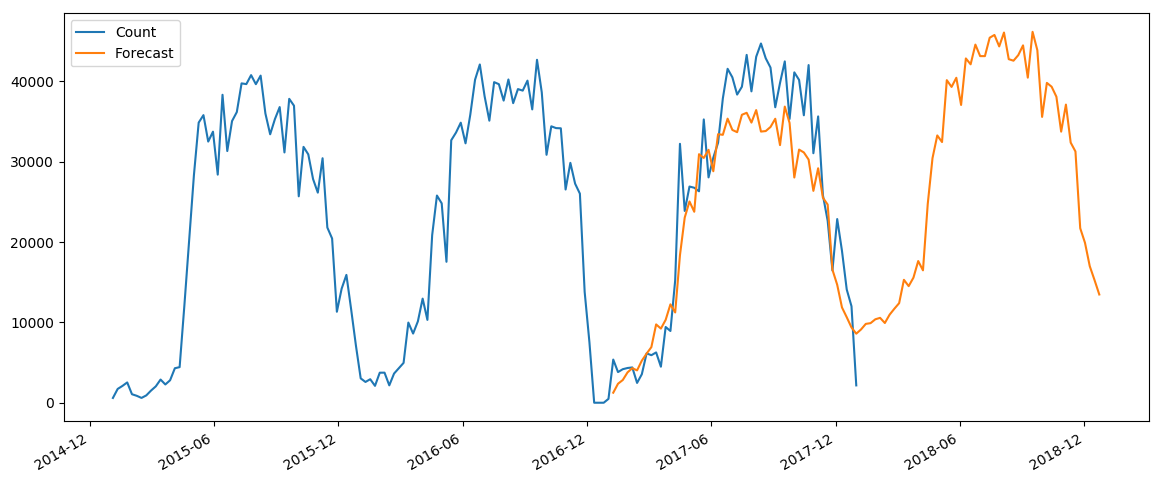

In [393]:
df_week['Forecast'] = sarima_week.predict(start=157-52, end=157+52, dynamic=True)  
df_week.plot(figsize=(14, 6));

In [651]:
combo_week = pd.concat([R_week, recorded_futureW], axis=0)

In [654]:
max(combo_week)

44690

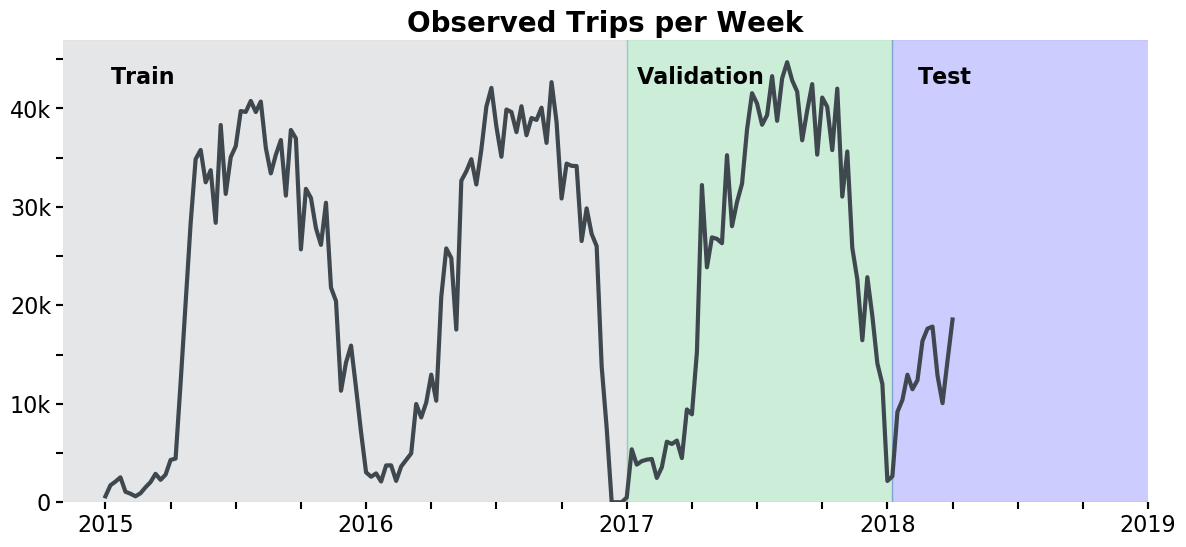

In [721]:
plt.style.use('default')
plt_color = '7d868c'
plt_color = 'white'
fig,ax = plt.subplots(figsize=(14,6), facecolor=plt_color)

combo_week.plot(color='#3e484e', lw=3, alpha=1, label='Observed', ax=ax)

ax.add_patch(patches.Rectangle((0,0), 2453, 47000, color='#7d868c', alpha=0.2))
t = ax.text(2350, 42500, 'Train', fontsize=16, fontweight='bold')
ax.add_patch(patches.Rectangle((2453,0), 53, 47000, color='#00a93d', alpha=0.2))
t = ax.text(2455, 42500, 'Validation', fontsize=16, fontweight='bold')
ax.add_patch(patches.Rectangle((2453+53,0), 53, 47000, color='blue', alpha=0.2))
t = ax.text(2453+53+5, 42500, 'Test', fontsize=16, fontweight='bold')

ax.set_frame_on(False)

ax.set_xticks(np.arange(2349, 2570, 13), minor=True)
ax.set_xticks(np.arange(2349, 2570, 52), minor=False)
ax.set_xticklabels([2015, 2016, 2017, 2018, 2019], minor=False)
# ax.set_xticks([2375, 2427, 2479], minor=True)
# ax.set_xticklabels(['Jul', 'Jul', 'Jul'], minor=True)
# ax.set_xlim(2349-10, 2529+10)
ax.set_xlabel('')

ax.set_title('Observed Trips per Week', fontdict={'size': 20, 'weight': 'bold'})
ax.set_yticks(np.arange(-10000, 45001, 5000), minor=True)
ax.set_yticks(np.arange(0, 40001, 10000), minor=False)
ax.set_yticklabels(['0', '10k', '20k', '30k', '40k'], minor=False)
ax.set_ylim(bottom=0)

fs = 16
ax.tick_params(which='both', axis='both', labelsize=fs, width=1.5, length=5)
# ax.legend(fontsize=fs, frameon=True, facecolor=plt_color, edgecolor=plt_color, loc=2) #, prop={'weight': 'bold'})
ax.set_frame_on(0)

ax.get_xticks(minor=False), ax.get_xticks(minor=True)
l = ax.get_xticklabels(minor=False)

In [718]:
for ll in l:
    print(ll)

Text(2349,0,'Jan\n2015')
Text(2401,0,'Jan\n2016')
Text(2453,0,'Jan\n2017')
Text(2505,0,'')


['', '/home/cneiderer/anaconda3/lib/python36.zip', '/home/cneiderer/anaconda3/lib/python3.6', '/home/cneiderer/anaconda3/lib/python3.6/lib-dynload', '/home/cneiderer/anaconda3/lib/python3.6/site-packages', '/home/cneiderer/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/home/cneiderer/.ipython']


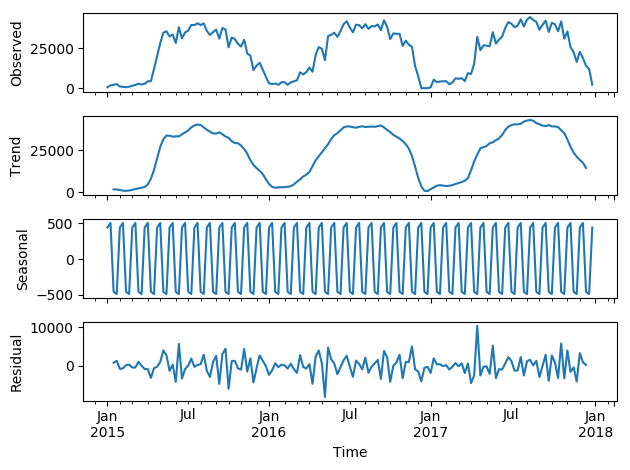

In [391]:
# decompose data into trend, seasonal, and residual
decomposition = sm.tsa.seasonal_decompose(R_week, model='additive', freq=4)
fig = decomposition.plot()

In [604]:
pred_future = sarima_week.predict(157, 157+12)
pred_future

2018-01-07     7004.126873
2018-01-14     6542.820569
2018-01-21     7074.330180
2018-01-28     7539.151273
2018-02-04     7842.053895
2018-02-11     6759.486187
2018-02-18     7997.704143
2018-02-25     9724.782382
2018-03-04    10165.681657
2018-03-11    12160.252423
2018-03-18    10987.011964
2018-03-25    13886.732870
2018-04-01    15017.114038
Freq: W-SUN, dtype: float64

In [605]:
recorded_future

starttime
2018-01-07     2639
2018-01-14     9171
2018-01-21    10394
2018-01-28    12948
2018-02-04    11474
2018-02-11    12388
2018-02-18    16378
2018-02-25    17626
2018-03-04    17839
2018-03-11    12855
2018-03-18    10059
2018-03-25    14406
2018-04-01    18557
Freq: W-SUN, Name: bikeid, dtype: int64

In [612]:
pred_future - recorded_future

2018-01-07    4365.126873
2018-01-14   -2628.179431
2018-01-21   -3319.669820
2018-01-28   -5408.848727
2018-02-04   -3631.946105
2018-02-11   -5628.513813
2018-02-18   -8380.295857
2018-02-25   -7901.217618
2018-03-04   -7673.318343
2018-03-11    -694.747577
2018-03-18     928.011964
2018-03-25    -519.267130
2018-04-01   -3539.885962
Freq: W-SUN, dtype: float64

In [ ]:
from sklearn.metrics import mean_absolute_error
print('MAE:', mean_absolute_error(pred_future, recorded_future))

In [617]:
def root_mean_squared_error(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean() ** .5
print('RMSE:', root_mean_squared_error(pred_future, recorded_future))

MAE: 4201.463786128865
RMSE: 4936.453386869598


In [619]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAPE:', mean_absolute_percentage_error(pred_future, recorded_future))

MAPE: 50.28678573380477


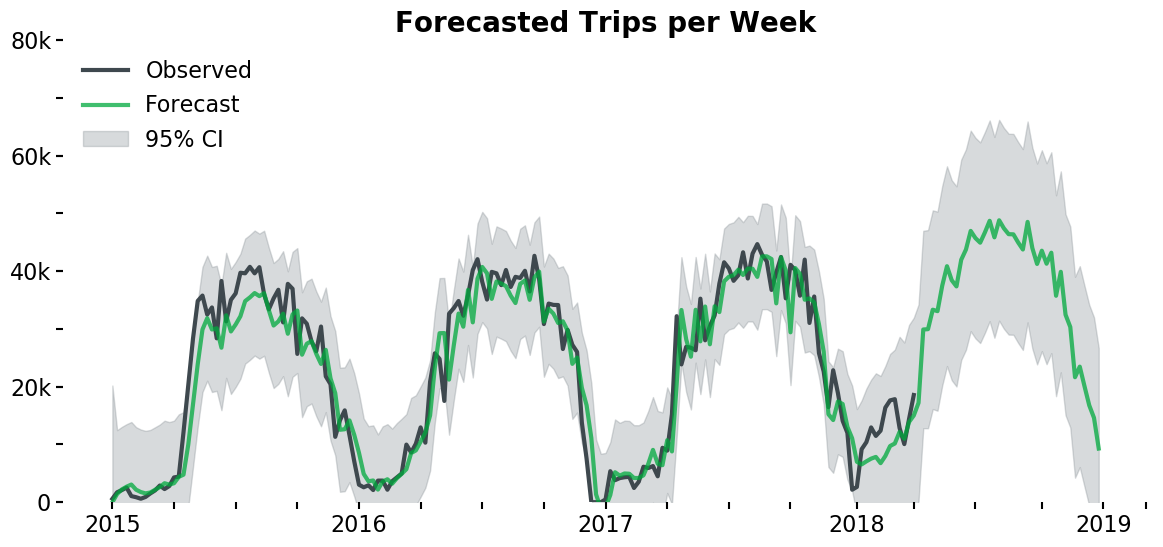

In [740]:
# pred = sarima_week.get_prediction(start=52*3, end=52*3+52*3, dynamic=False)
pred = sarima_week.get_prediction(start=0, end=52*3+52*1, dynamic=False)
# pred = sarima_week.get_prediction(start=0, end=52*3, dynamic=False)
pred_ci = pred.conf_int()

plt.style.use('default')
plt_color = '7d868c'
plt_color = 'white'
fig,ax = plt.subplots(figsize=(14,6), facecolor=plt_color)

combo_week.plot(color='#3e484e', lw=3, alpha=1, label='Observed', ax=ax) # '#7d868c', '#3e484e'
# sarima_week.predict().plot(ax=ax)
pred.predicted_mean.plot(color='#00a93d', lw=3, alpha=0.75, label='Forecast', ax=ax) # this is using all available info
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='#7d868c', alpha=0.3, label='95% CI')

ax.set_frame_on(False)

ax.set_xlabel('')
# ax.set_xticks(np.arange(2349, 2570, 13), minor=True)
# ax.set_xticks(np.arange(2349, 2570, 52), minor=False)
# ax.set_xticklabels([2015, 2016, 2017, 2018, 2019], minor=False)

ax.set_title('Forecasted Trips per Week', fontdict={'size': 20, 'weight': 'bold'})
# ax.set_ylabel('Trips per Week', fontdict={'size': 20, 'weight': 'bold'})
ax.set_yticks(np.arange(-10000, 80001, 10000), minor=True)
ax.set_yticks(np.arange(0, 80001, 20000), minor=False)
ax.set_yticklabels(['0', '20k', '40k', '60k', '80k', '80k'], minor=False)
ax.set_ylim(bottom=0)

fs = 16
ax.tick_params(which='both', axis='both', labelsize=fs, width=1.5, length=5)
ax.legend(fontsize=fs, frameon=True, facecolor=plt_color, edgecolor=plt_color, loc=2) #, prop={'weight': 'bold'})
ax.set_frame_on(0)

In [235]:
#add monthly dates to df_month
start = dt.strptime("2018-01-31", "%Y-%m-%d")
month_list = [start + relativedelta(month=x) for x in range(1,13)]
future_month = pd.DataFrame(index=month_list, columns= df_month.columns)
df_month = pd.concat([df_month, future_month])

In [236]:
df_month.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2015-01-31 to 2018-12-31
Data columns (total 2 columns):
Count       36 non-null object
Forecast    36 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


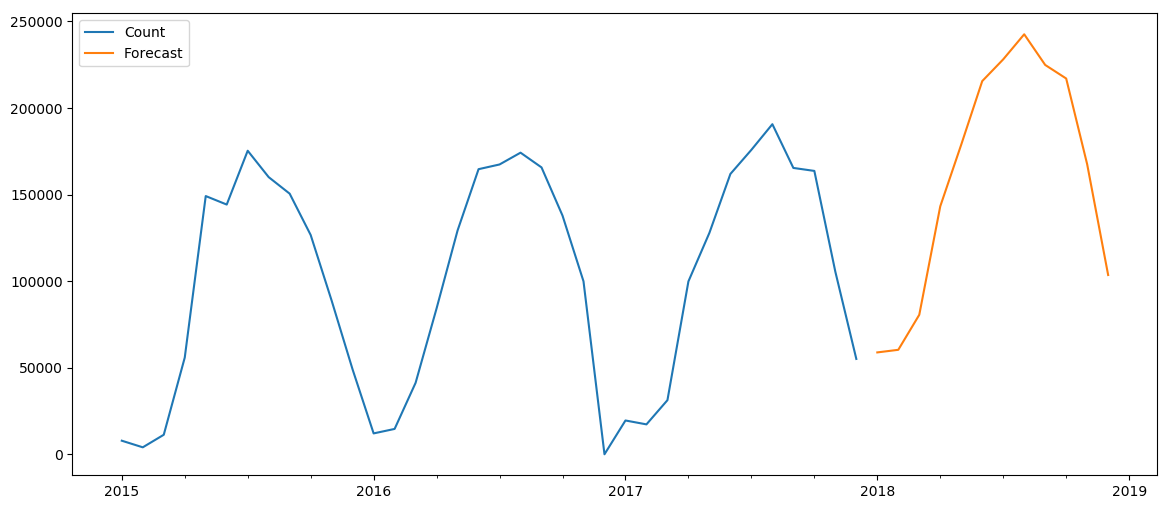

In [237]:
df_month['Forecast'] = sarima_month.predict(start=36, end=48, dynamic=True)  
df_month
df_month.plot(figsize=(14, 6));

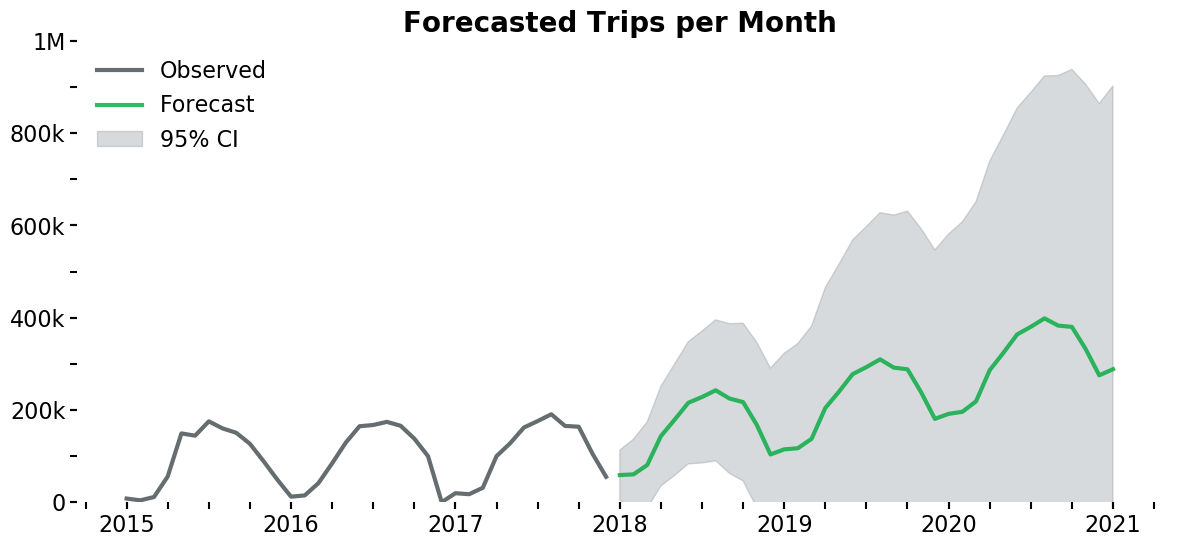

In [238]:
pred = sarima_month.get_prediction(start=36, end=72, dynamic=True)
pred_ci = pred.conf_int()

plt.style.use('default')
plt_color = '7d868c'
plt_color = 'white'
fig,ax = plt.subplots(figsize=(14,6), facecolor=plt_color)

R_month.plot(color='#3e484e', lw=3, alpha=0.8, label='Observed', ax=ax) # '#7d868c', '#3e484e'
pred.predicted_mean.plot(color='#00a93d', lw=3, alpha=0.8, label='Forecast', ax=ax) # this is using all available info
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='#7d868c', alpha=0.3, label='95% CI')
ax.set_xlabel('')
# ax.set_ylabel('Trips Per Month', fontdict={'size': 20})
# ax.set_xticks([], minor=True)
ax.set_title('Forecasted Trips per Month', fontdict={'size': 20, 'weight': 'bold'})
ax.set_yticks(np.arange(-400000, 1000001, 100000), minor=True)
ax.set_yticks(np.arange(-400000, 1000001, 200000), minor=False)
ax.set_yticklabels(['-400k', '200k', '0', '200k', '400k', '600k', '800k', '1M'], minor=False)
ax.set_ylim(bottom=0)

fs = 16
ax.tick_params(which='both', axis='both', labelsize=fs, width=1.5, length=5)
ax.legend(fontsize=fs, frameon=True, facecolor=plt_color, edgecolor=plt_color, loc=2) #, prop={'weight': 'bold'})
ax.set_frame_on(0)
test = ax.get_yticklabels()

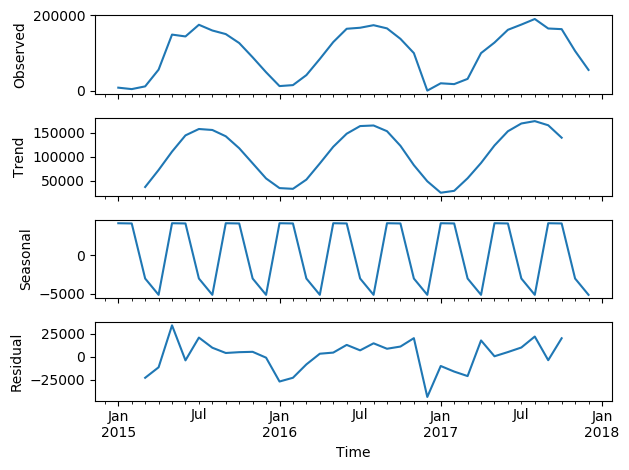

In [368]:
# decompose data into trend, seasonal, and residual
decomposition = sm.tsa.seasonal_decompose(R_month, model='additive', freq=4)
fig = decomposition.plot()